In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Propósito de este estudio:

Aplicar los conocimientos adquiridos de los capítulos 2 a 7 del libro enfocandome en el tema de data leakage, feature selection, hiperparametrizacion básica de modelos y técnicas de modelado compuestas como Boosting, Voting y Blending

In [7]:
!pip install catboost

In [8]:
# Manejo de datos
import pandas as pd
import numpy as np
from collections import Counter

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = None

# Tipos y utilidades
from typing import List, Optional
import os
import joblib
import datetime

# Modelos y aprendizaje supervisado
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Selección de características
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Métricas
from sklearn.metrics import (
    f1_score,
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Muestreo
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Transformadores personalizados
from sklearn.base import BaseEstimator, TransformerMixin

#Funciones Utilizadas en este work
import sys
sys.path.append('/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral')
from funciones_diabetes import *




In [9]:
df = pd.read_csv('/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/diabetes_semestral.csv')
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


# Split de la Data para evitar Leakage

In [10]:
def split(data_preparada):

    size_train = round(len(data_preparada) * 0.75)

    train_ids = data_preparada.sample(n=size_train, random_state=2024).index


    train = (
        data_preparada.loc[data_preparada.index.isin(train_ids)]
        .sample(frac=1, random_state=2024)
        .reset_index(drop=True)
    )
    test = (
        data_preparada.loc[~data_preparada.index.isin(train_ids)]
        .sample(frac=1, random_state=2024)
        .reset_index(drop=True)
    )
    return train, test


X_train_df, X_test_df = split(df)
X_train_df.info()
X_test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    int64  
 1   Glucose                   576 non-null    int64  
 2   BloodPressure             576 non-null    int64  
 3   SkinThickness             576 non-null    int64  
 4   Insulin                   576 non-null    int64  
 5   BMI                       576 non-null    float64
 6   DiabetesPedigreeFunction  576 non-null    float64
 7   Age                       576 non-null    int64  
 8   Outcome                   576 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 40.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies          

A partir de este punto ya no se va a tocar más el conjunto de test hasta que se vaya a aplicar el flujo de procesamiento de datos antes de probar el score del modelo ganador, ya que usarlo en una etapa anterior es FILTRADO DE INFORMACIÓN, lo que puede llevar a resultados falsos en las métricas ya que el modelo contará con información que el modelo en producción nunca tendría.


# Validation Set

Este es un split nuevo del conjunto de train que nos sirve para ir evaluando nuestros modelos y observar si hay overfit o underfit, qué técnicas y parámetros ayudan al modelo y todo esto evitando algún posible DATA LEAKAGE

In [11]:
y = X_train_df.pop('Outcome')
X = X_train_df
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state = 2024)
print(f"La cantidad de valores de train es de: {X_train.shape[0]}")
print(f"La cantidad de valores de test es de: {X_val.shape[0]}")

La cantidad de valores de train es de: 432
La cantidad de valores de test es de: 144


# Preprocesamiento

# Imputacion de Valores Nulos


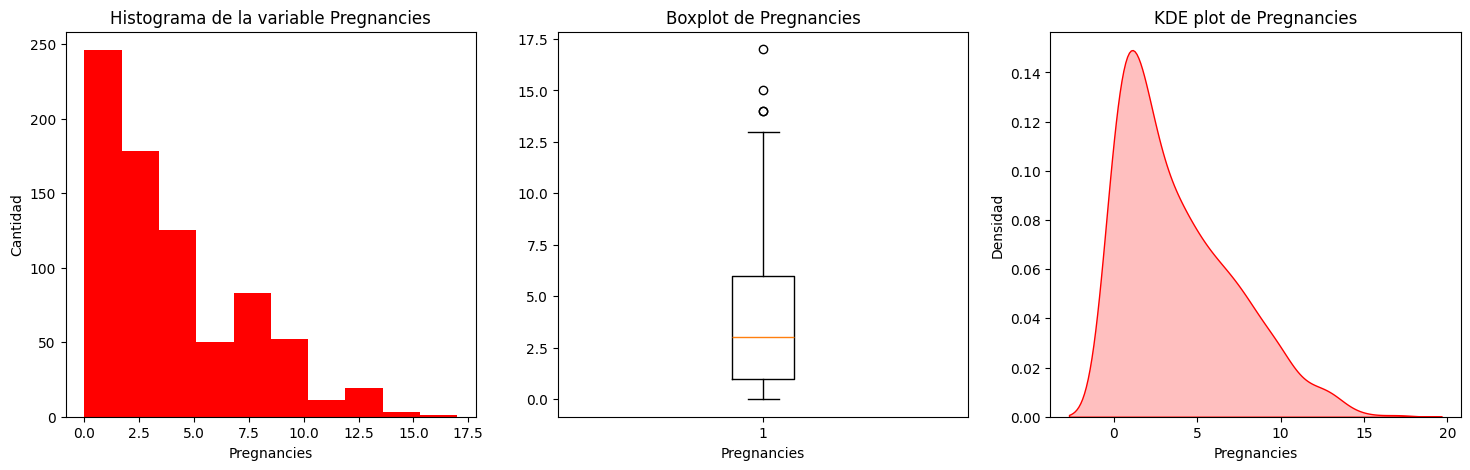


 El sesgo de la variable es 0.9016739791518588


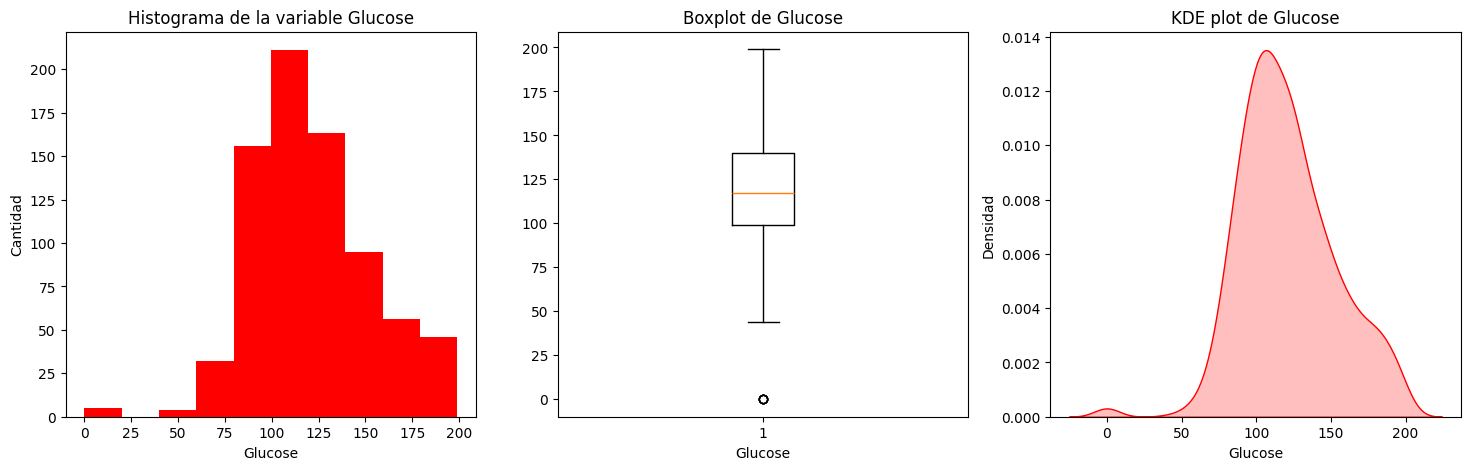


 El sesgo de la variable es 0.17375350179188992


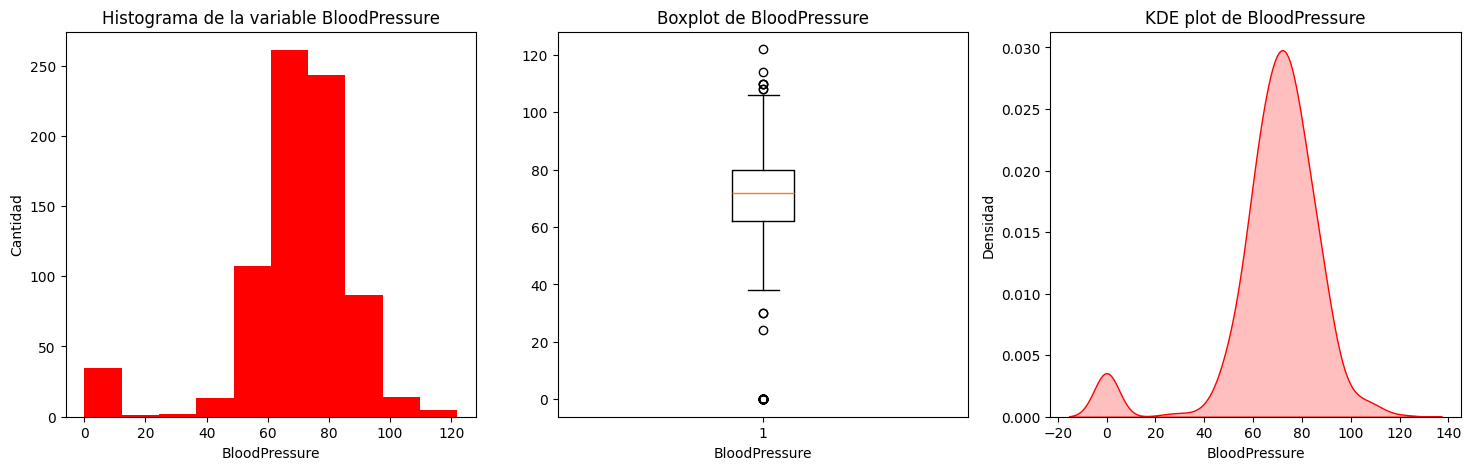


 El sesgo de la variable es -1.8436079833551302


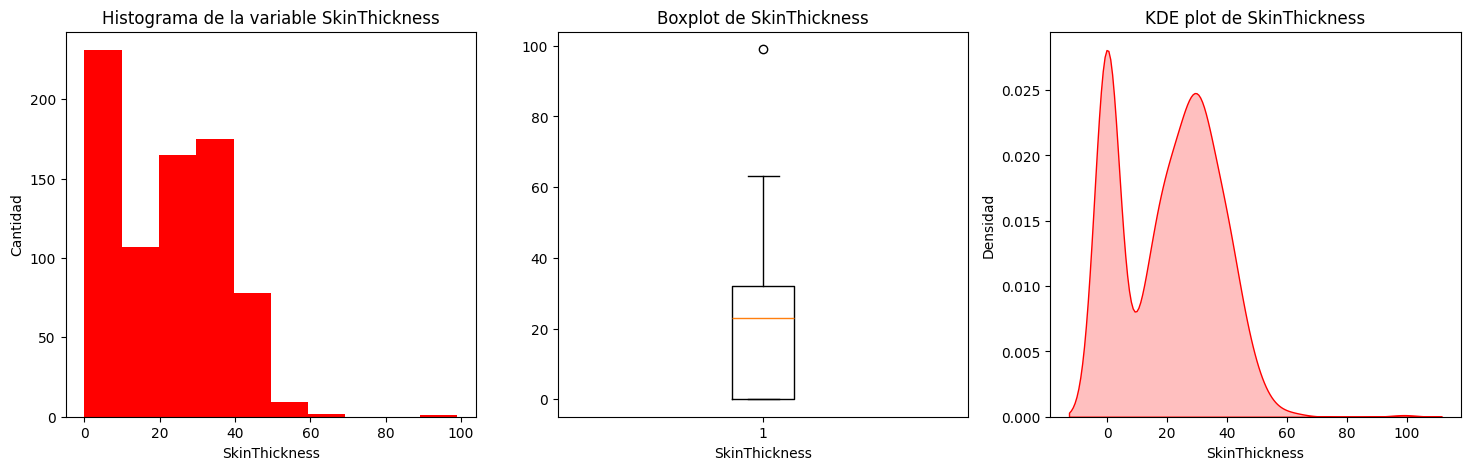


 El sesgo de la variable es 0.10937249648187608


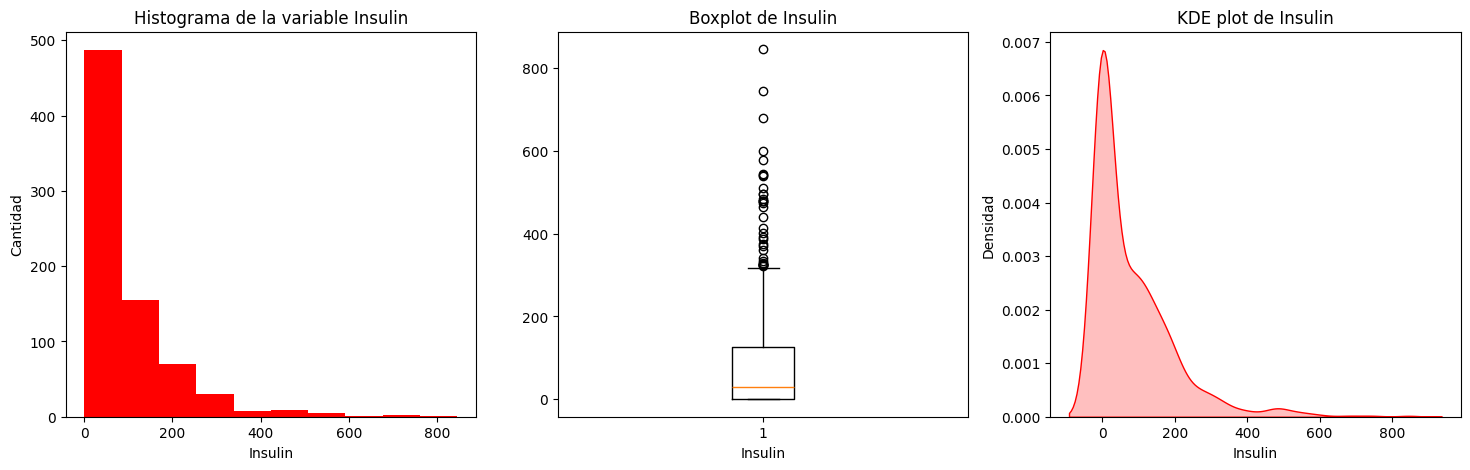


 El sesgo de la variable es 2.272250858431574


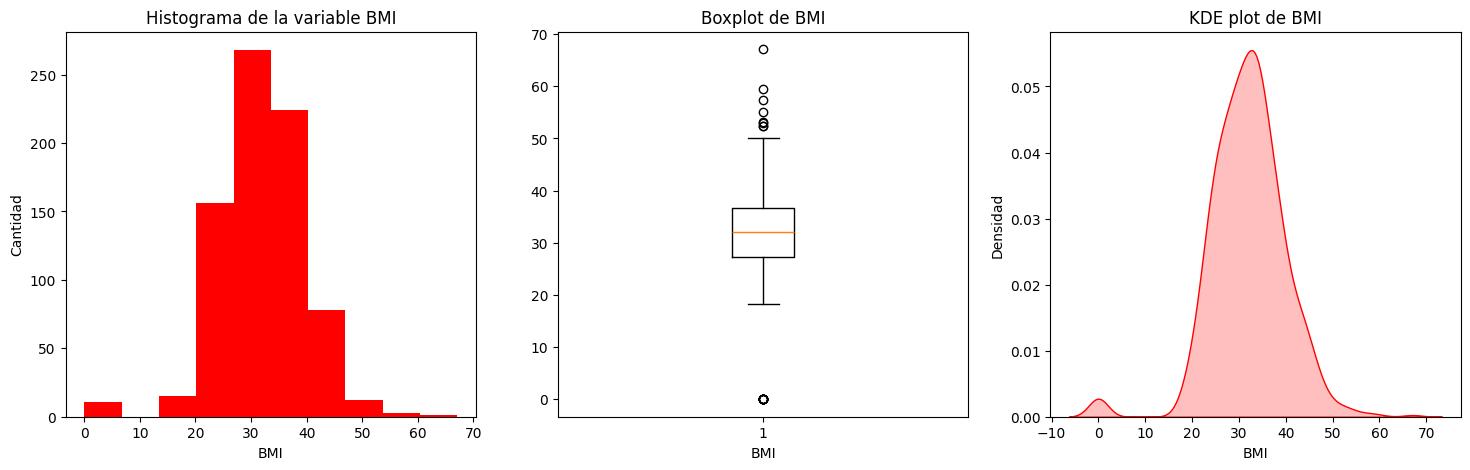


 El sesgo de la variable es -0.42898158845356543


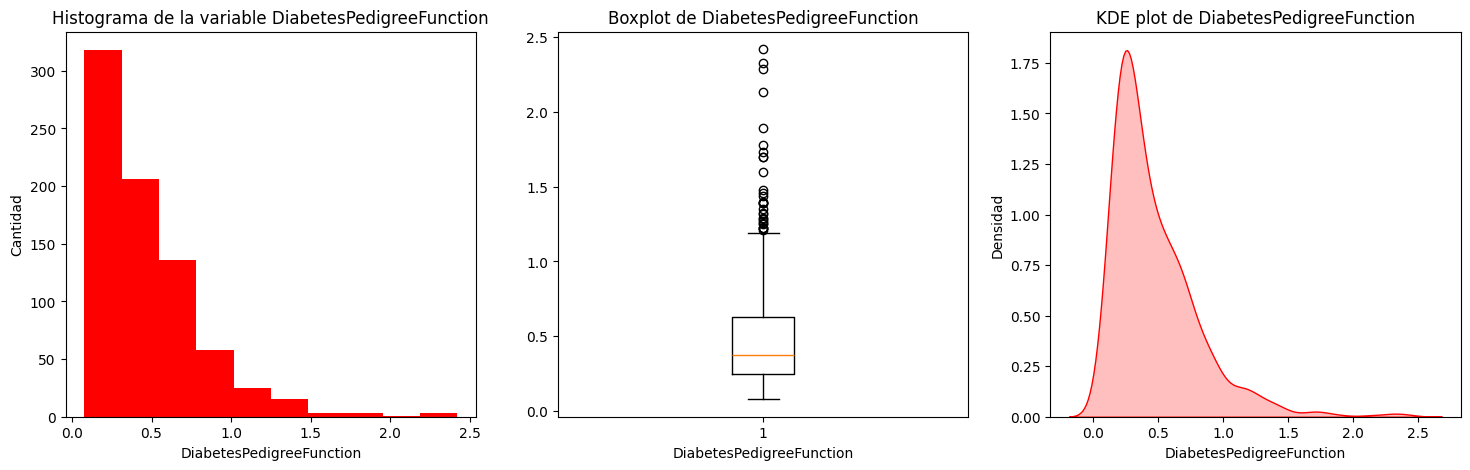


 El sesgo de la variable es 1.919911066307204


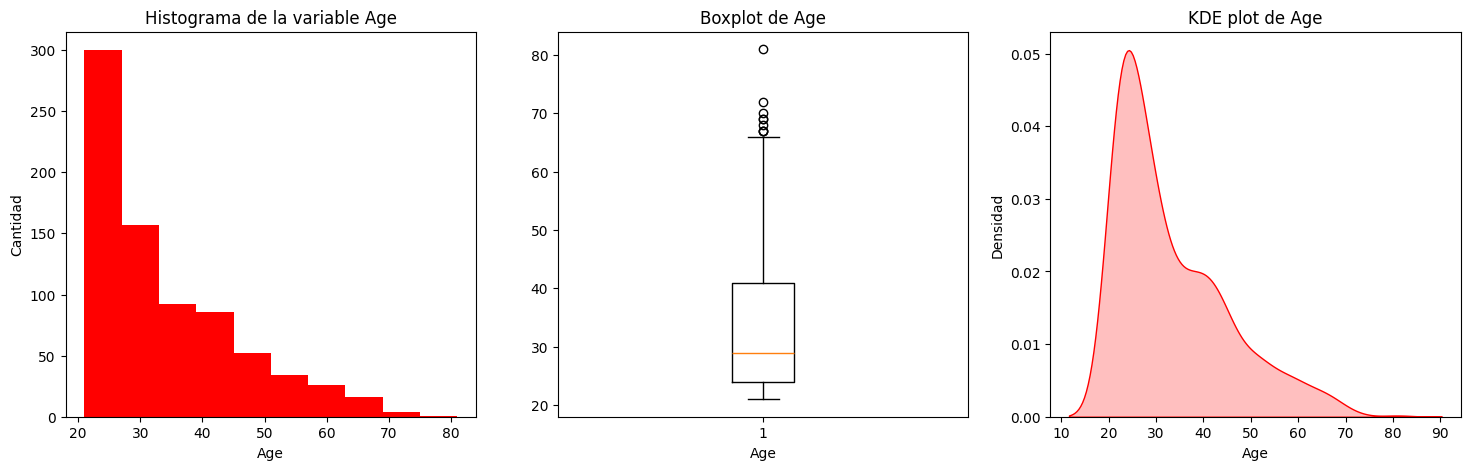


 El sesgo de la variable es 1.1295967011444805


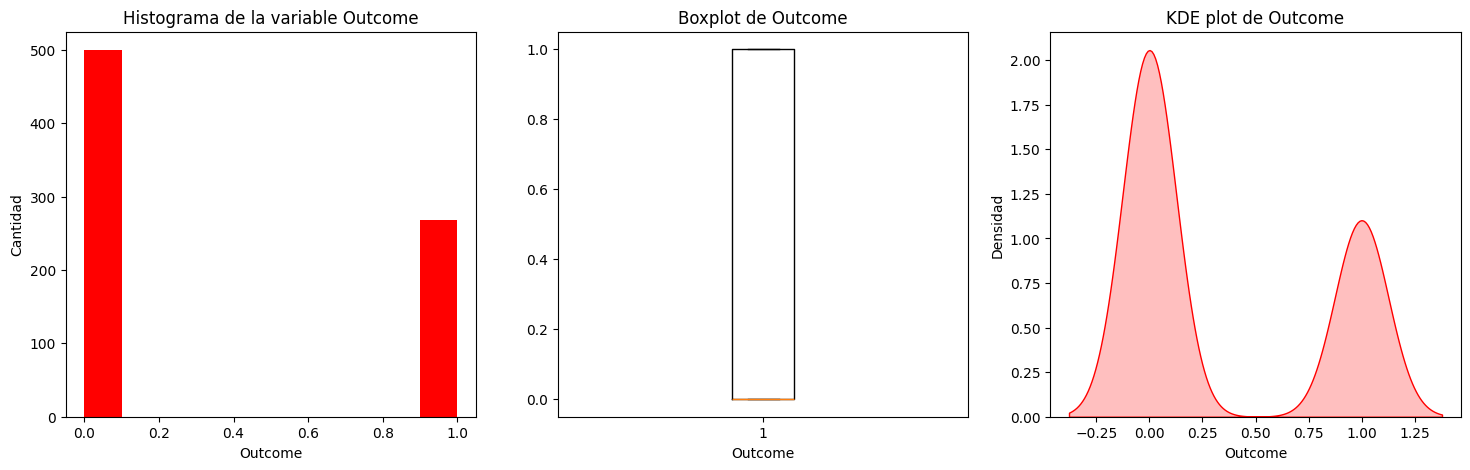


 El sesgo de la variable es 0.635016643444986


In [12]:
for col in df.columns:
    estudio_univariante(df, col)

# Valores Nulos

In [13]:
for col in df:
    if col != 'Outcome':
        result = len(df.loc[df[col] == 0])
        print(f"El numero de ceros de la {col}: {result}")

El numero de ceros de la Pregnancies: 111
El numero de ceros de la Glucose: 5
El numero de ceros de la BloodPressure: 35
El numero de ceros de la SkinThickness: 227
El numero de ceros de la Insulin: 374
El numero de ceros de la BMI: 11
El numero de ceros de la DiabetesPedigreeFunction: 0
El numero de ceros de la Age: 0


In [14]:
def imputar_ceros(df, col_imputar, test = False, medias = None):
    if test:
        if medias is None:
            raise ValueError("Debes proporcionar un diccionario de medias para test=True.")
        for col in col_imputar:
            if col in medias:
                df[col] = df[col].replace(0, medias[col])
        return df
    medias = {}
    for col in col_imputar:
        df[col] = df[col].replace(0, np.NaN)
        mean = np.nanmean(df[col])
        df[col] = df[col].replace(np.NaN, mean)
        medias[col] = mean
    return df, medias




En este dataset, las variables que estaban missing fueron imputadas con 0. La idea de esta función es imputar mediante la media (Sin contar los registros con cero de cada columna). También esta funcion regresa un diccionario con las medias de cada columna (sin contar ceros) para que estos valores sean aplicados a las particiones de X_val y X_test debido a que en sistemas de produccion, no se sabe la media exacta en caso de necesitar imputación, por lo que utilizar esta aproximación sería considerado LEAKAGE DE INFORMACIÓN.

In [15]:
col_imputar = ['BMI', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin']
X_train_imputed = X_train.copy() #Definiendo un checkpoint para no tener que reiniciar el notebook en caso de error
X_train_imputed, dicc_mean_val = imputar_ceros(X_train_imputed, col_imputar)

Aplicando la funcion a al set de validación.
IMPORTANTE: HABER CORRIDO ESTA FUNCION PARA X_TRAIN Y ASI TENER EL DICCIONARIO CON LAS MEDIAS.

In [16]:
X_val_imputed = X_val.copy()
X_val_imputed = imputar_ceros(X_val_imputed,col_imputar, True, dicc_mean_val)

y_test = X_test_df.pop('Outcome') #Separarle a este que todavia tiene la var dependiente junta
X_test_imputed = X_test_df.copy()
X_test_imputed = imputar_ceros(X_test_imputed,col_imputar, True, dicc_mean_val)

# Creando Nuevas Caracteristicas

La idea es intentar capturar patrones no lineales de la data, linealizando la relaciones mediante formulas, (ratios, potencias, dominio del tema). Aplicando antes de las transformaciones para simplificar el trabajo de revertir antes de aplicar.

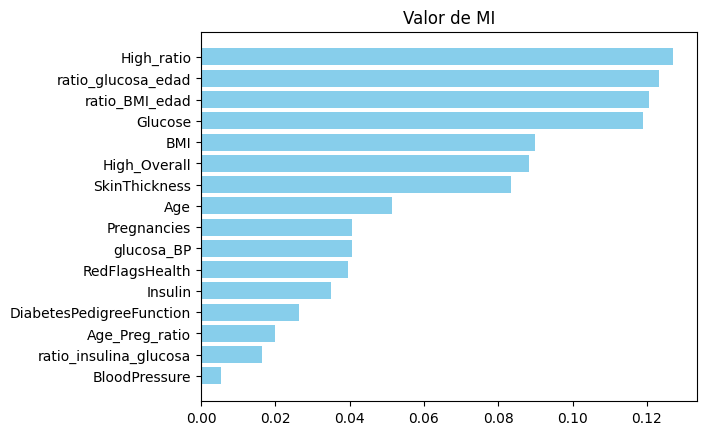

<Figure size 1000x800 with 0 Axes>

In [17]:
def evaluar_salud(X):
    puntaje = 0
    if 100 <= X['Glucose'] <= 125:
        puntaje += 1
    elif X['Glucose'] >= 126:
        puntaje += 2
    if 120 <= X['BloodPressure'] <= 129 and X['BloodPressure'] < 80:
        puntaje += 1
    elif 130 <= X['BloodPressure'] <= 139 or 80 <= X['BloodPressure'] <= 89:
        puntaje += 2
    elif X['BloodPressure'] >= 140 or X['BloodPressure'] >= 90:
        puntaje += 5
    if 25 <= X['BMI'] <= 29.9:
        puntaje += 1
    elif 30 <= X['BMI'] <= 34.9:
        puntaje += 2
    elif 35 <= X['BMI'] <= 39.9:
        puntaje += 3
    elif X['BMI'] >= 40:
        puntaje += 5
    if X['Insulin'] >= 200:
        puntaje += 5
    return puntaje

def fe_propuestas(X):
    X['RedFlagsHealth'] = (X.apply(evaluar_salud, axis = 1)) - X['Pregnancies'] #No tomar en cuenta pregnancies, muchos ceros
    X['High_Overall'] = X.sum(axis=1)
    X['ratio_glucosa_edad'] = (2 *X['Age']*(X['Glucose']))/(X['Age'])
    X['ratio_BMI_edad'] = (2 * X['Age'] * X['BMI'])/(X['Age'] + X['BMI'])
    X['ratio_insulina_glucosa'] =  (X['Age'] * X['Glucose']) / X['Insulin']
    X['glucosa_BP'] = (X['BloodPressure'] * X['Glucose']) / X['Insulin']
    X['Age_Preg_ratio'] = (X['Age'] * (X['Pregnancies'] + 1e-6) )  / X['Age']
    X['High_ratio'] = (
        X['BloodPressure']
        + X['Glucose']
        + (3 * X['BMI'])
        + X['Insulin']
        + (X['DiabetesPedigreeFunction'] * 60)
        + (X['Pregnancies'] * 20)
        + (X['Age'] * 2)
        + (X['SkinThickness'] * 3)
    )

    return X

def mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name='MI_SCORE', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending = True)
    width = np.arange(len(mi_scores))
    ticks = list(mi_scores.index)
    plt.barh(width, mi_scores, color="skyblue")
    plt.yticks(width, ticks)
    plt.title('Valor de MI')

    plt.figure(figsize=(10,8))
    plt.show()
    return mi_scores

#Aplicacion de las funciones con sus checkpoints

X_train_eng = X_train_imputed.copy()
X_val_eng = X_val_imputed.copy()
X_test_eng = X_test_imputed.copy()

X_train_eng = fe_propuestas(X_train_eng)
X_val_eng = fe_propuestas(X_val_eng)
X_test_eng = fe_propuestas(X_test_eng)

scores = mi_scores(X_train_eng, y_train)

#scores = mi_scores(X_train_transf,y_train)
#Buena para regresiones lineales y comparar la Y con una X cat
#sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

# Transformando la Data
Muchos de los algoritmos de IA requieren de datos con una distribución normal para poder cumplir sus supuestos o requisitos de que sus predicciones sean justificables, por lo que en esta etapa aplicaremos transformaciones matemáticas para intentar conseguir distribuciones con forma de campana de Gauss (normal o casi)
Se usaran dos métodos:

1. Transformación BOXCOX
2. Transformación Logaritmica

¿Por qué estos dos?
Porque este dataset no cuenta con valores negativos muy conveniente para aplicar estos dos metodos de suavizado.

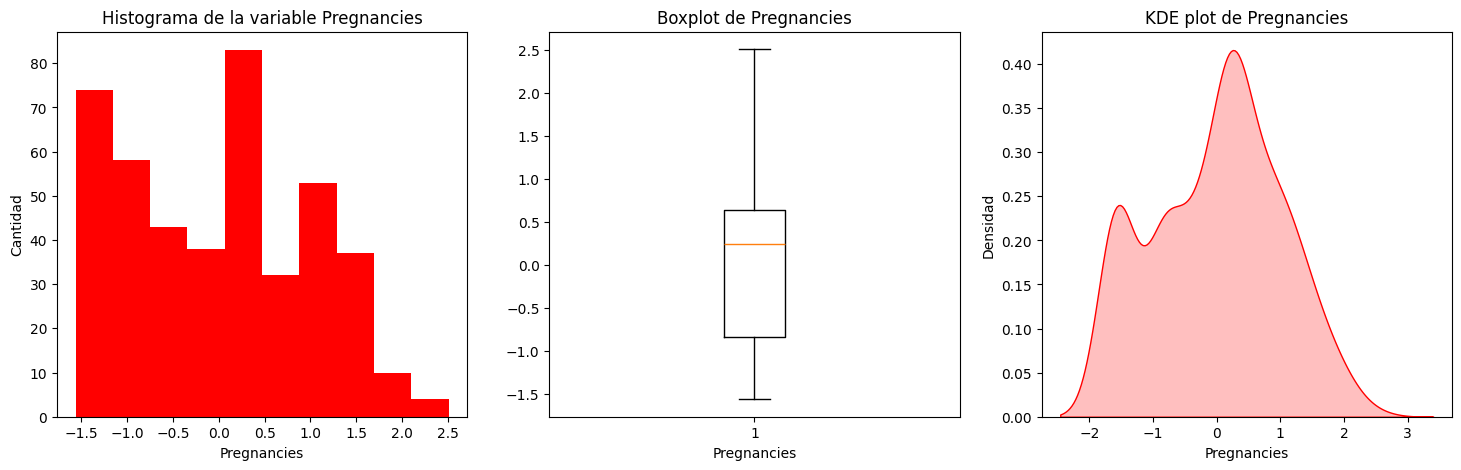


 El sesgo de la variable es -0.06280237409324012


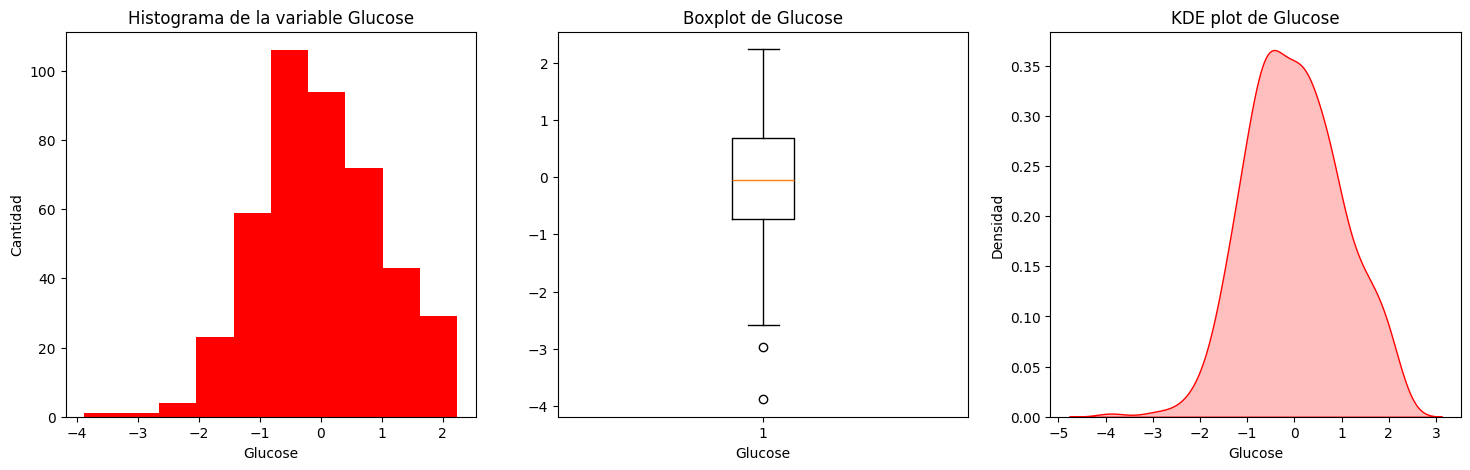


 El sesgo de la variable es -0.00037367253417193474


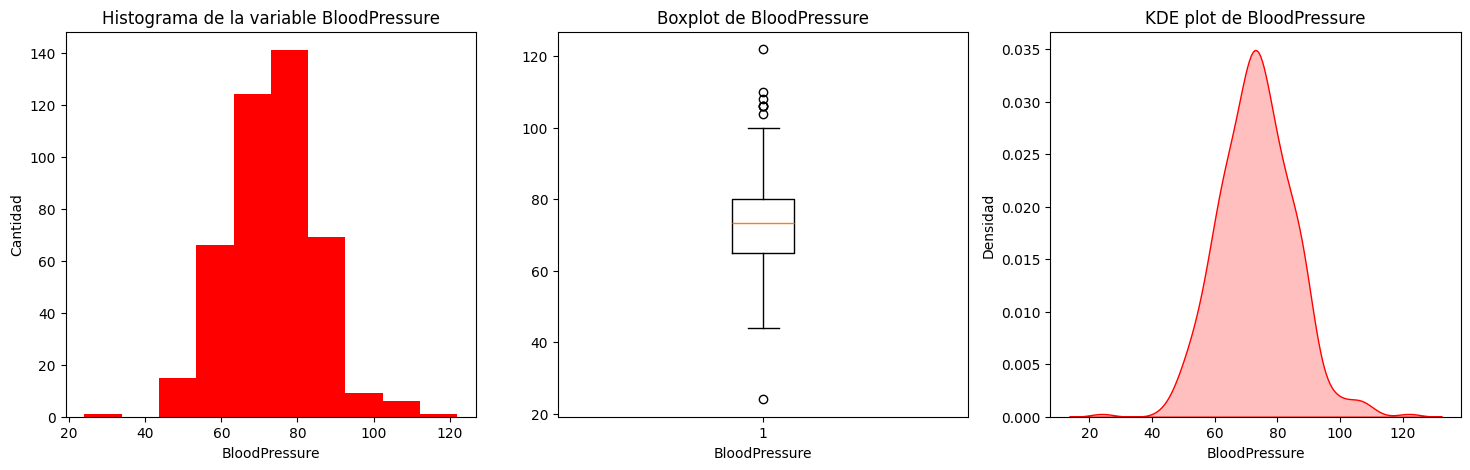


 El sesgo de la variable es 0.18151756271851546


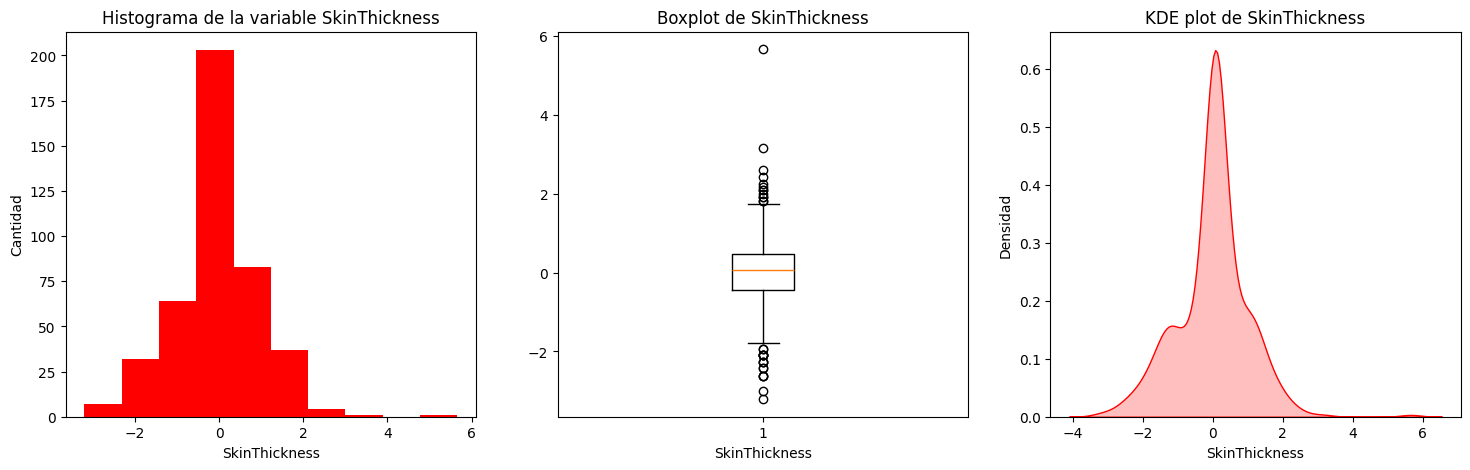


 El sesgo de la variable es 0.1083039193158771


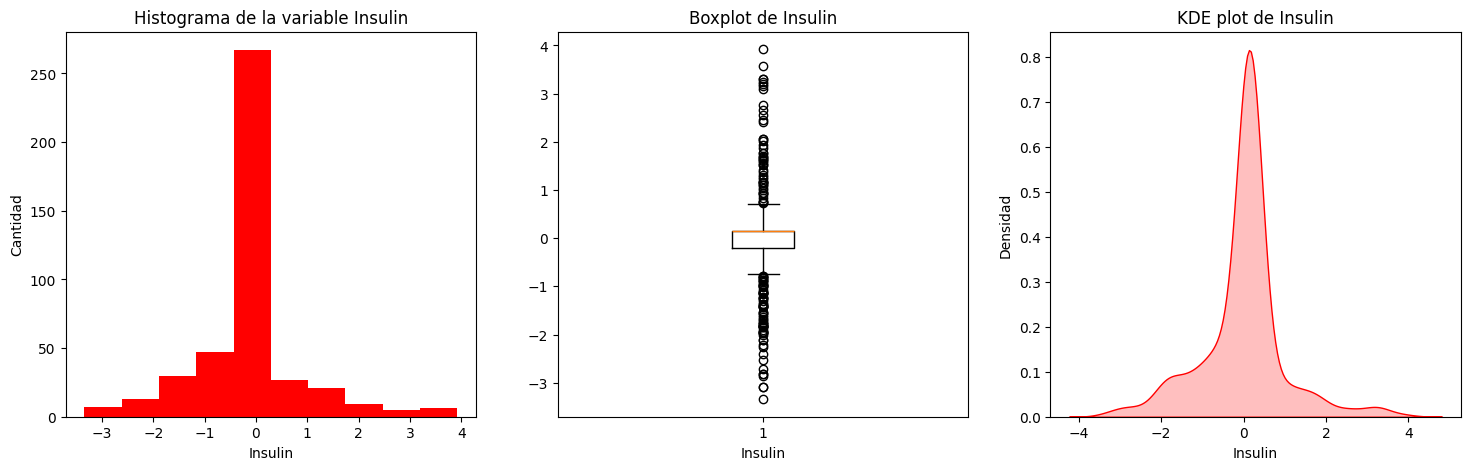


 El sesgo de la variable es 0.1374776955471306


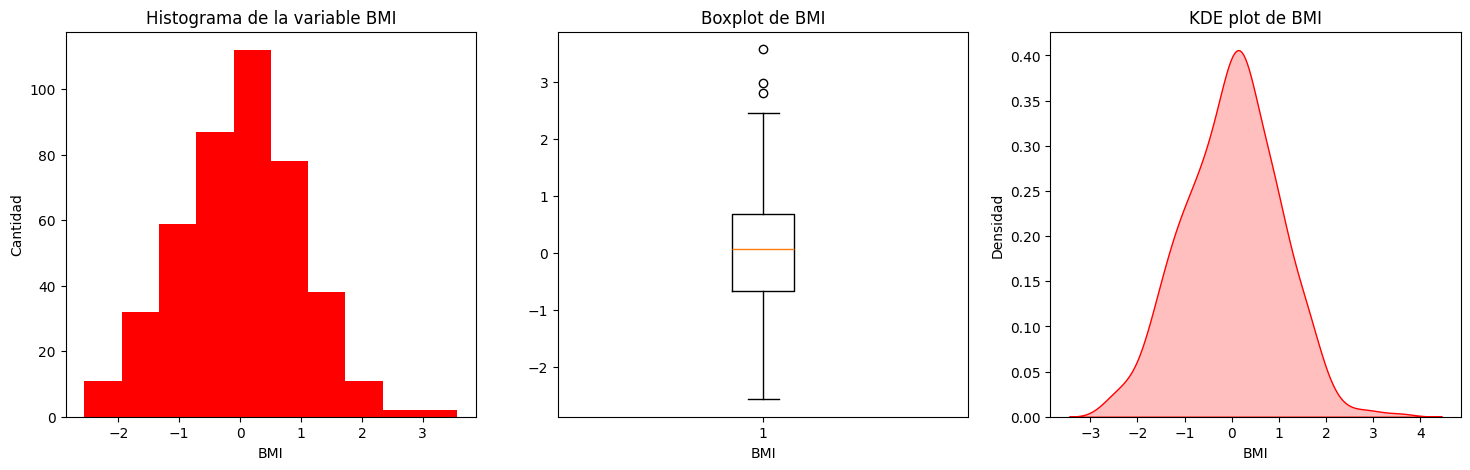


 El sesgo de la variable es 0.00010178106515884228


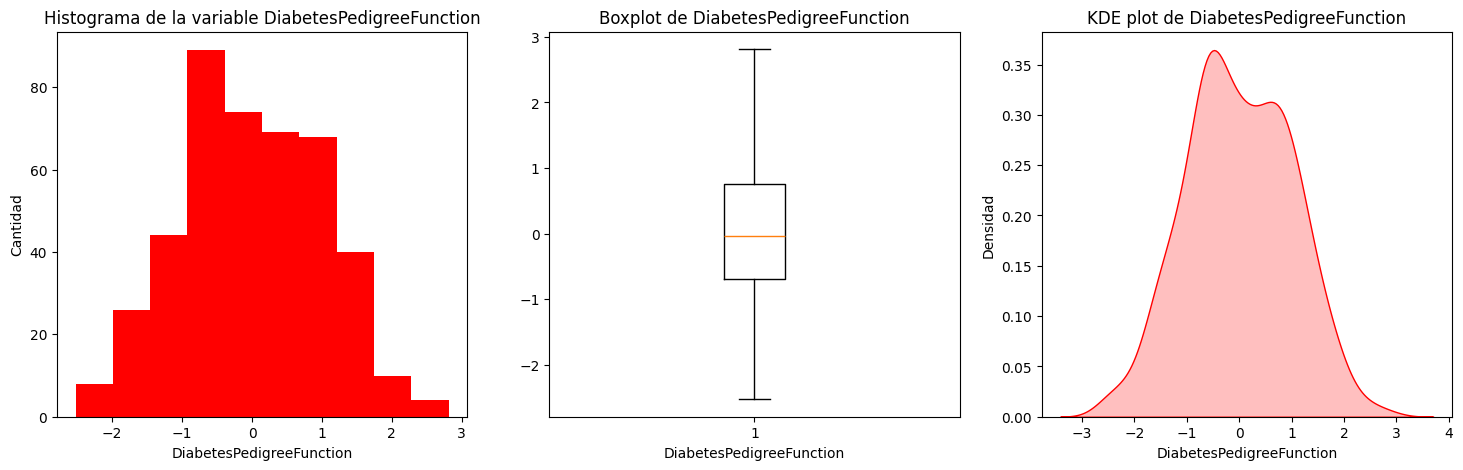


 El sesgo de la variable es 0.005778490388947059


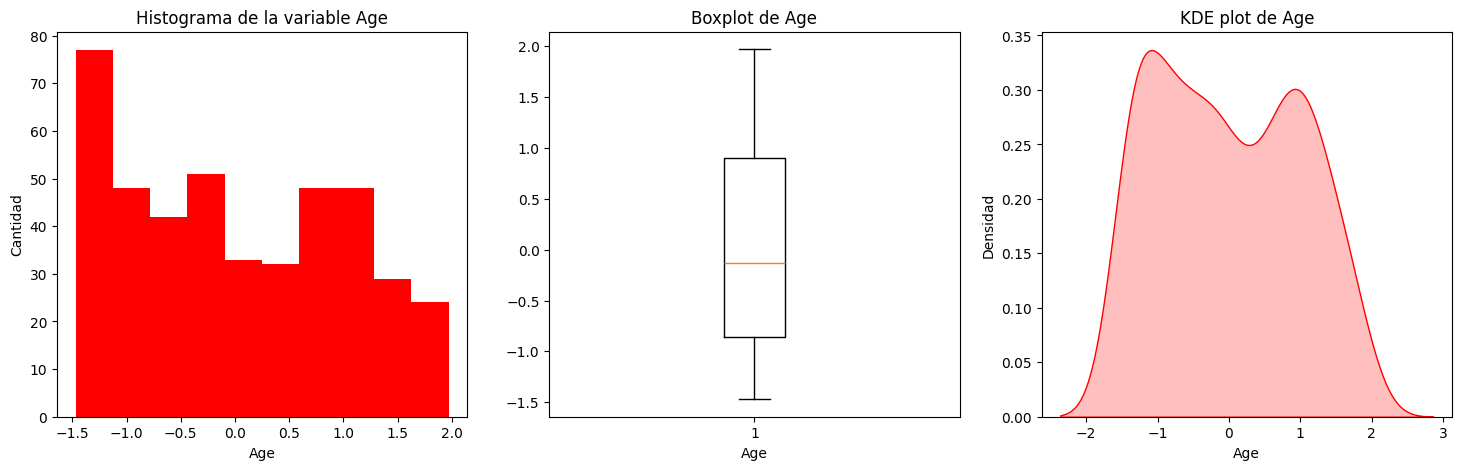


 El sesgo de la variable es 0.1369221682498741


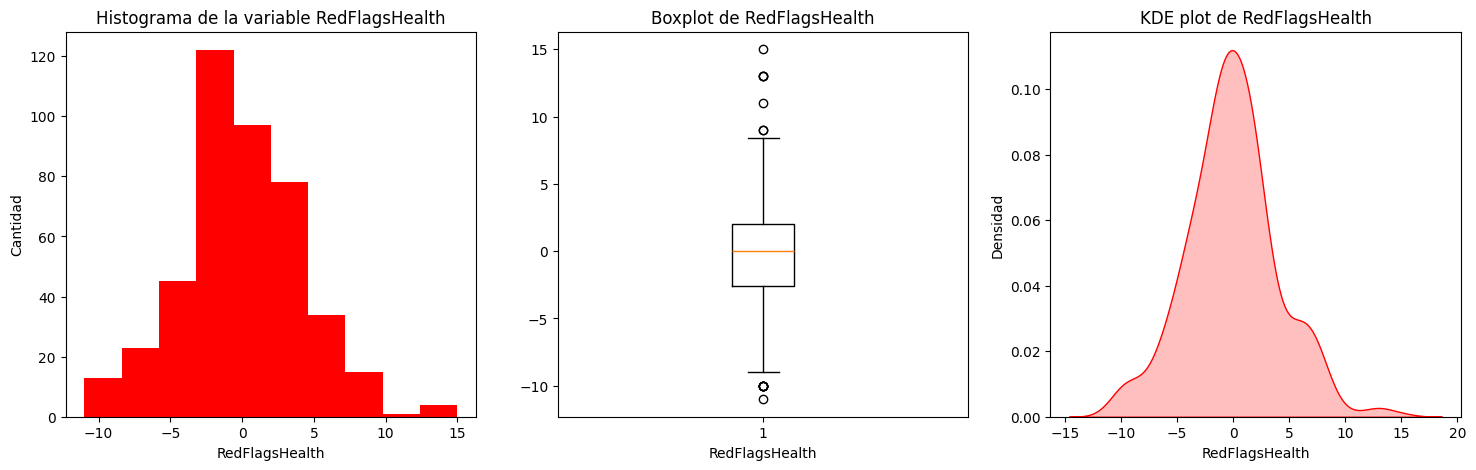


 El sesgo de la variable es 0.2332698063834603


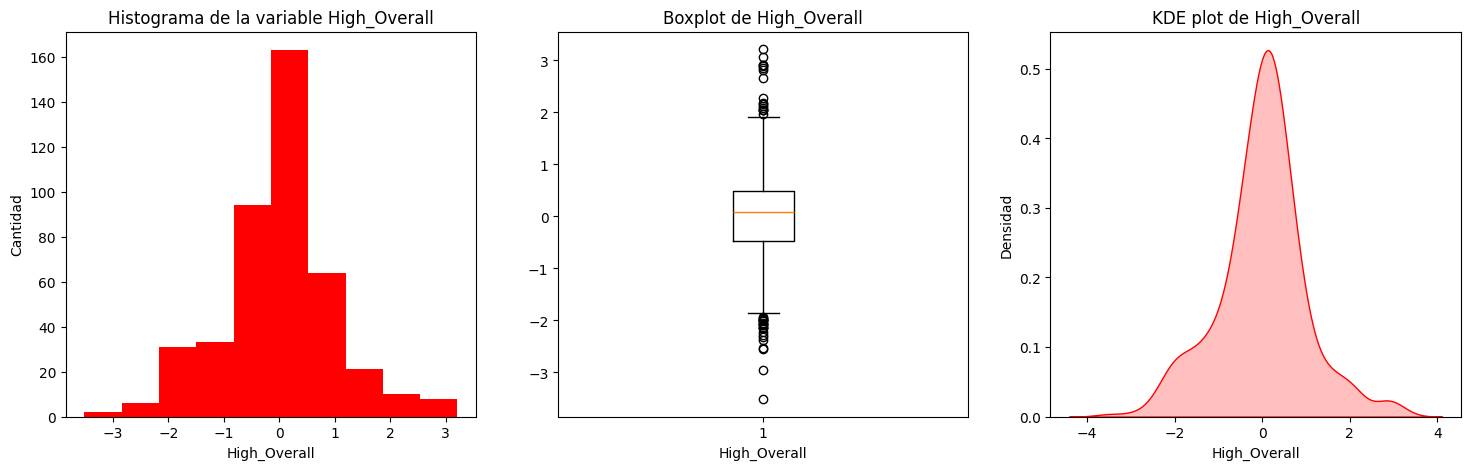


 El sesgo de la variable es -0.013338463514789208


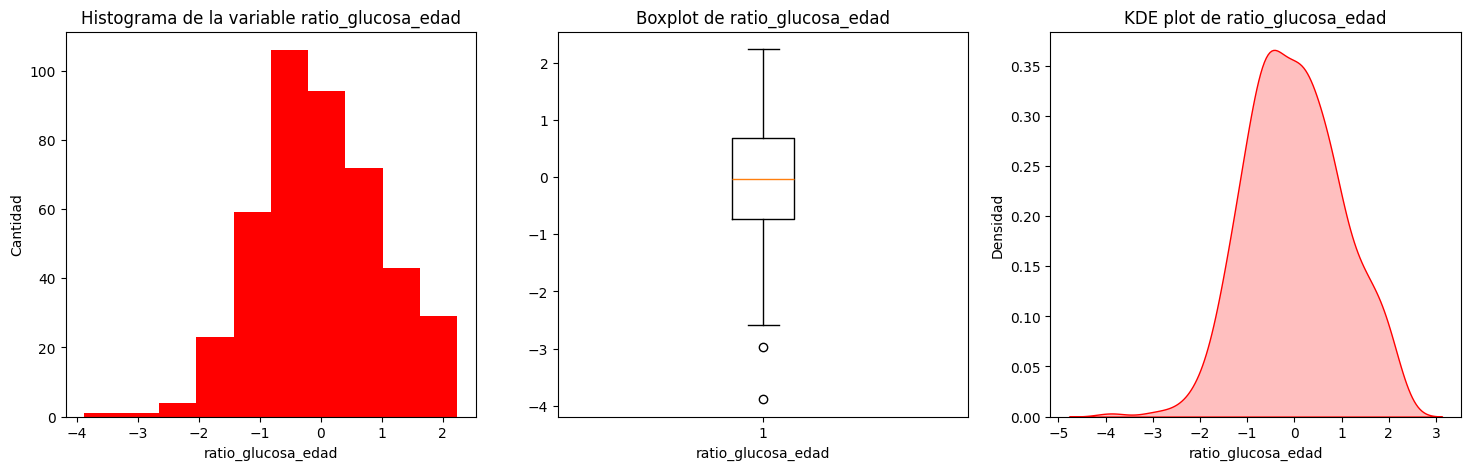


 El sesgo de la variable es -0.00037363318349395604


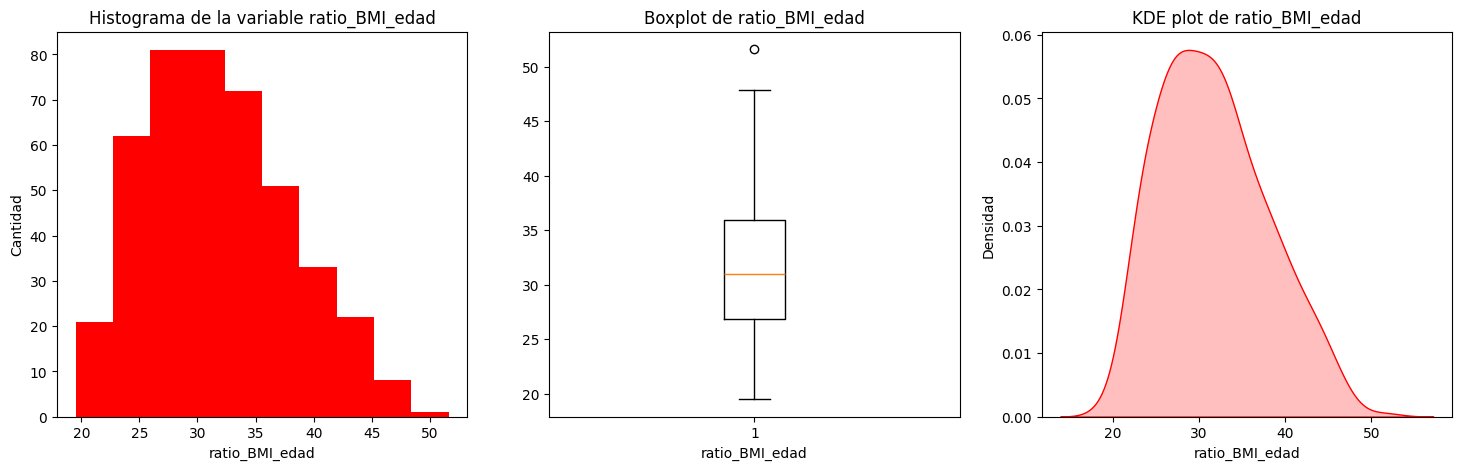


 El sesgo de la variable es 0.4417995821815197


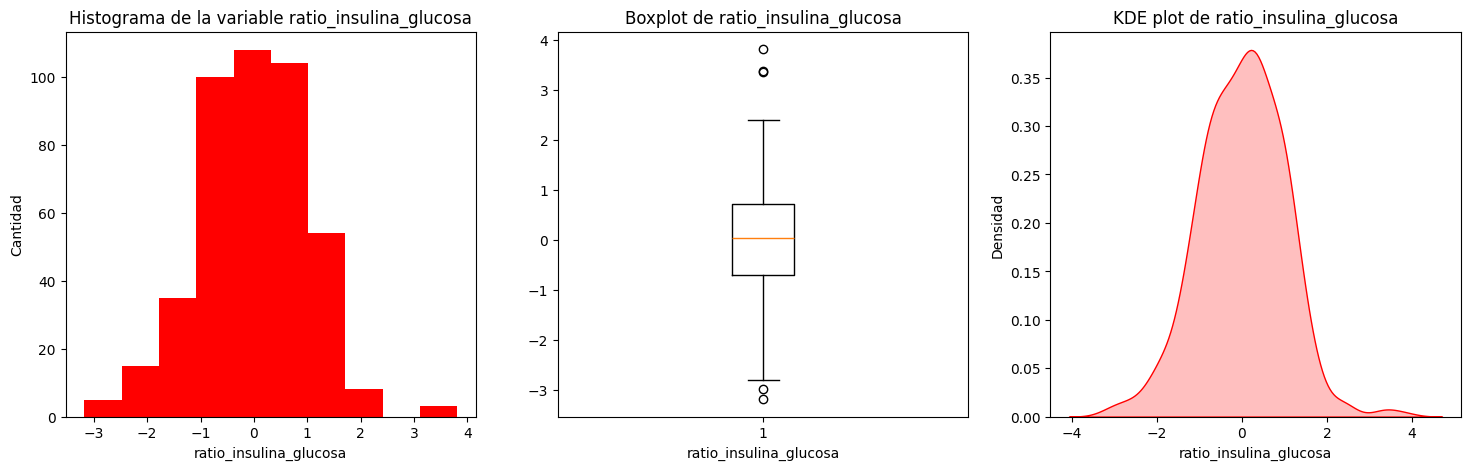


 El sesgo de la variable es -0.020659744235987768


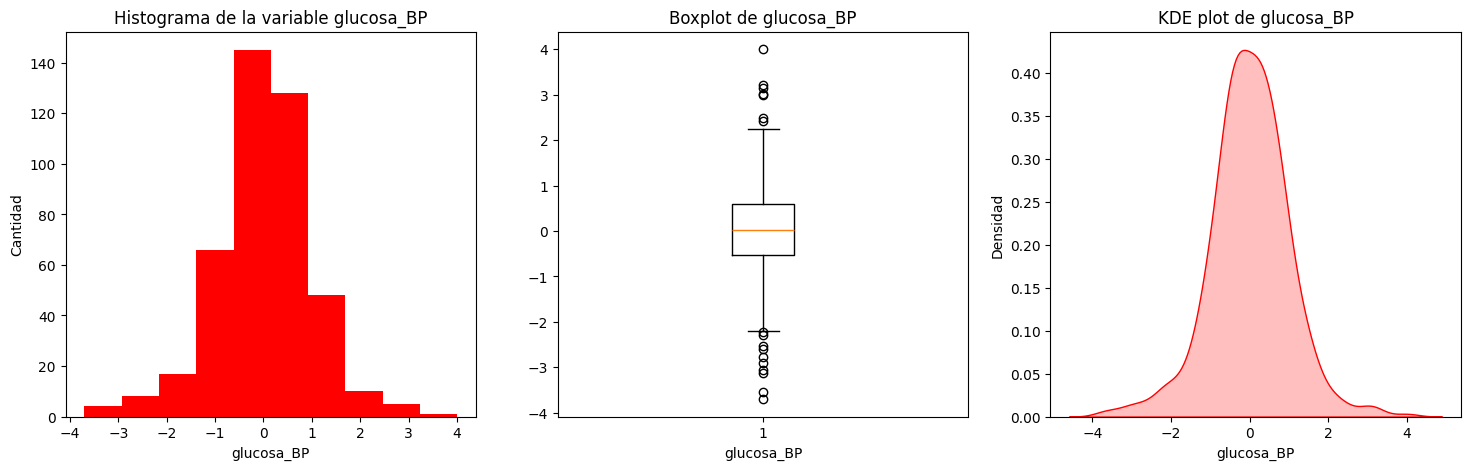


 El sesgo de la variable es -0.08601214635219726


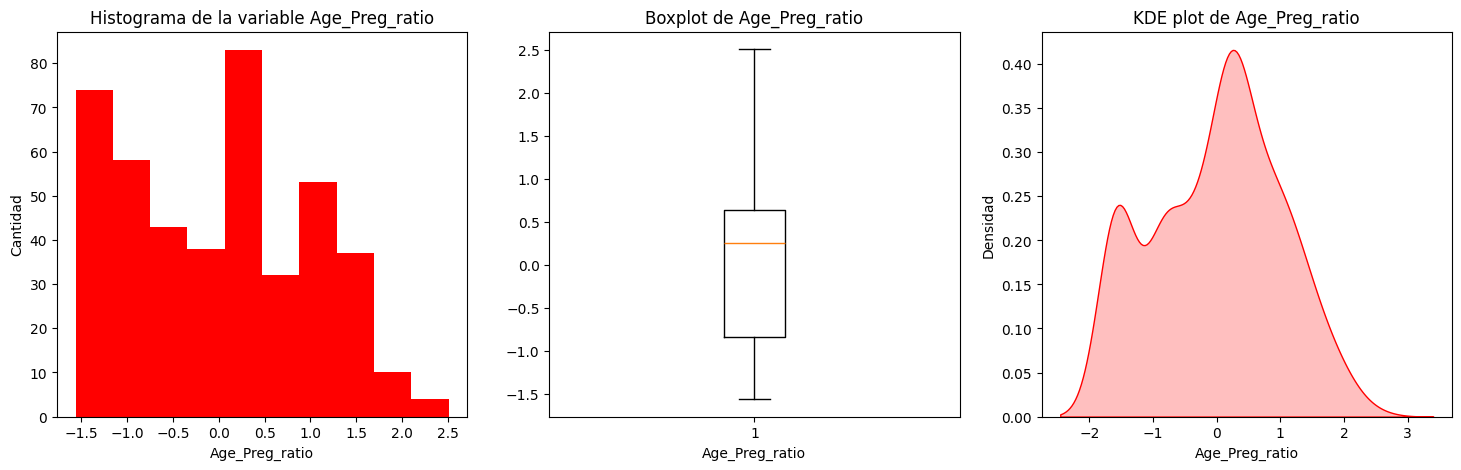


 El sesgo de la variable es -0.06280227033354079


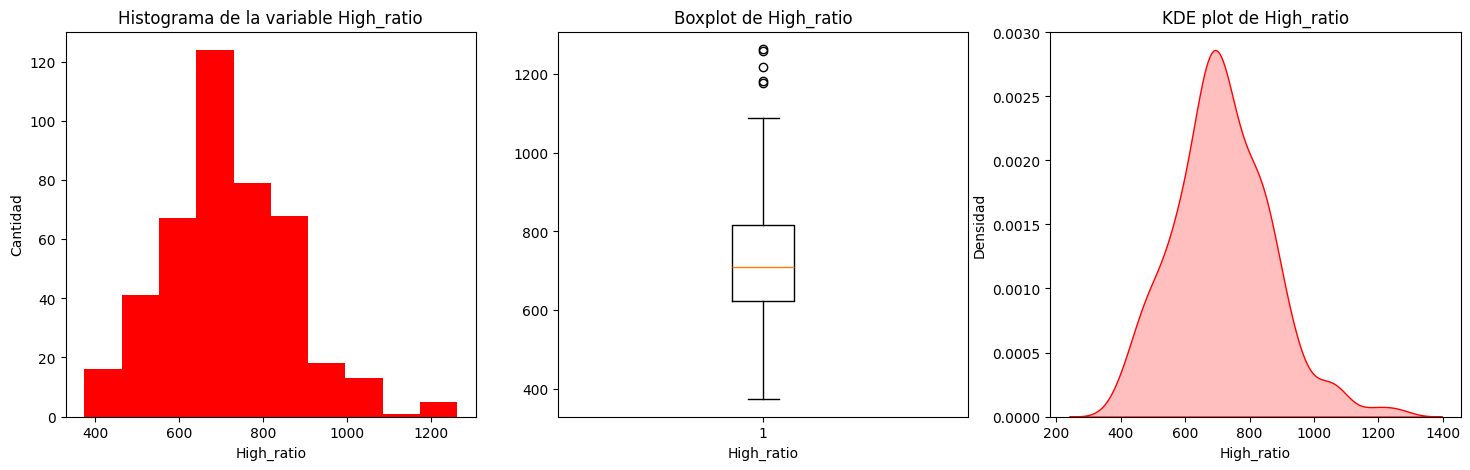


 El sesgo de la variable es 0.4636542359809619


In [18]:
def transformar_datos(X, X_val, X_test, metodo="box-cox"):
    columnas_transformar = []
    columnas_log = []
    for col in X.columns:
        if X[col].skew() >= 0.5:
            columnas_transformar.append(col)


    pt = PowerTransformer(method=metodo)


    X[columnas_transformar] = pt.fit_transform(X[columnas_transformar])
    X_val[columnas_transformar] = pt.transform(X_val[columnas_transformar])
    X_test[columnas_transformar] = pt.transform(X_test[columnas_transformar])


    for col in columnas_transformar:
        if X[col].skew() >= 0.25:
            columnas_log.append(col)
            X[col] = np.log(X[col] + 1e-6)
            X_val[col] = np.log(X_val[col] + 1e-6)
            X_test[col] = np.log(X_test[col] + 1e-6)

    return X, X_val, X_test, pt, columnas_transformar, columnas_log

def revertir_transformaciones(X, pt_transf, columnas_transformar, columnas_log):
    for col in columnas_log:
        if X[col].skew() >= 0.25:
            X[col] = np.exp(X[col]) - 1e-6

    if X[col].skew() >= 0.5:
        X[columnas_transformar] = pt.inverse_transform(X[columnas_transformar])

    return X

X_train_transf = X_train_eng.copy()
X_val_transf = X_val_eng.copy()
X_test_transf = X_test_eng.copy()

X_transf, X_val_transf, X_test_transf, pt_transf, col_transf, col_log = transformar_datos(X_train_transf , X_val_transf, X_test_transf)
for col in X_train_transf.columns:
    estudio_univariante(X_train_transf, col)

# Proceso de selección de características

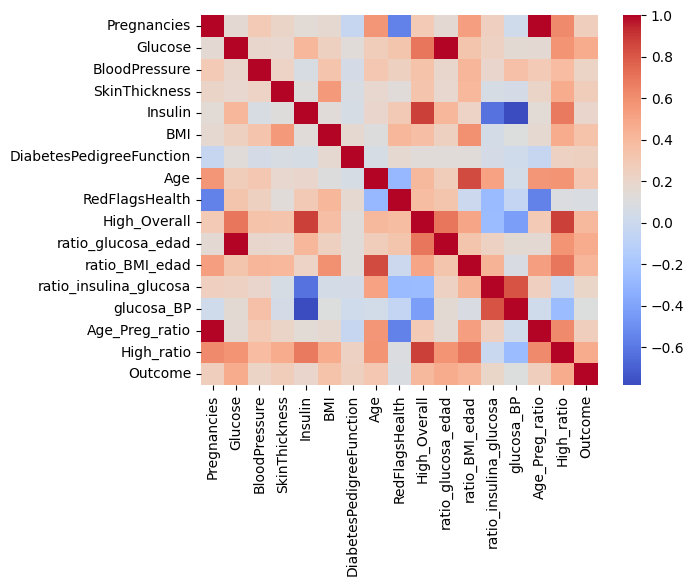

<Figure size 2500x2500 with 0 Axes>

In [19]:
train_transf = pd.concat([X_train_transf, y_train], axis = 1)
sns.heatmap(train_transf.corr(), cmap = 'coolwarm')
plt.figure(figsize = (25,25))
plt.show()

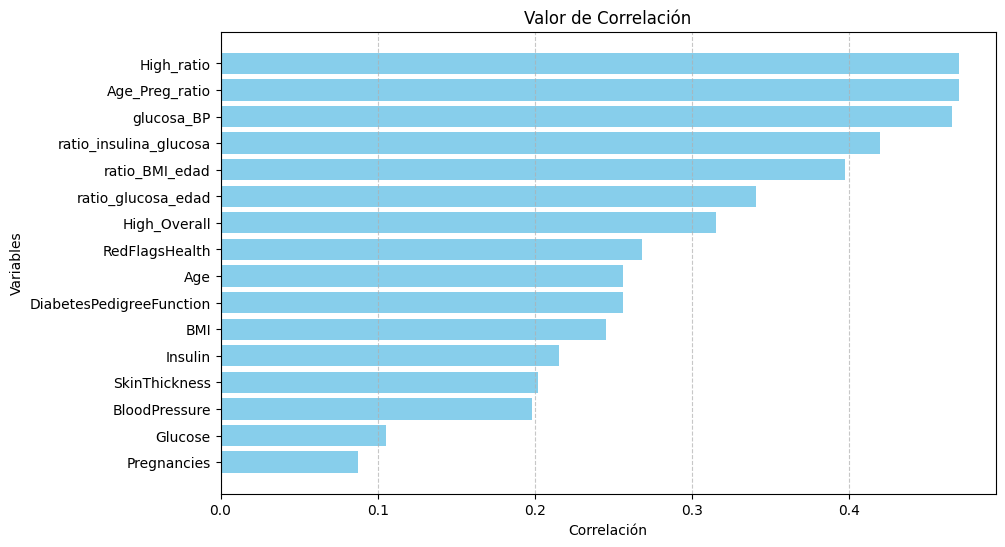

In [20]:
correlaciones(X_train_transf, y_train)

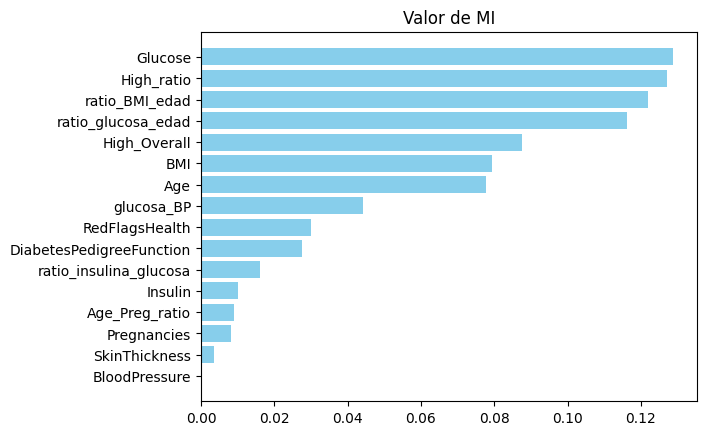

<Figure size 1000x800 with 0 Axes>

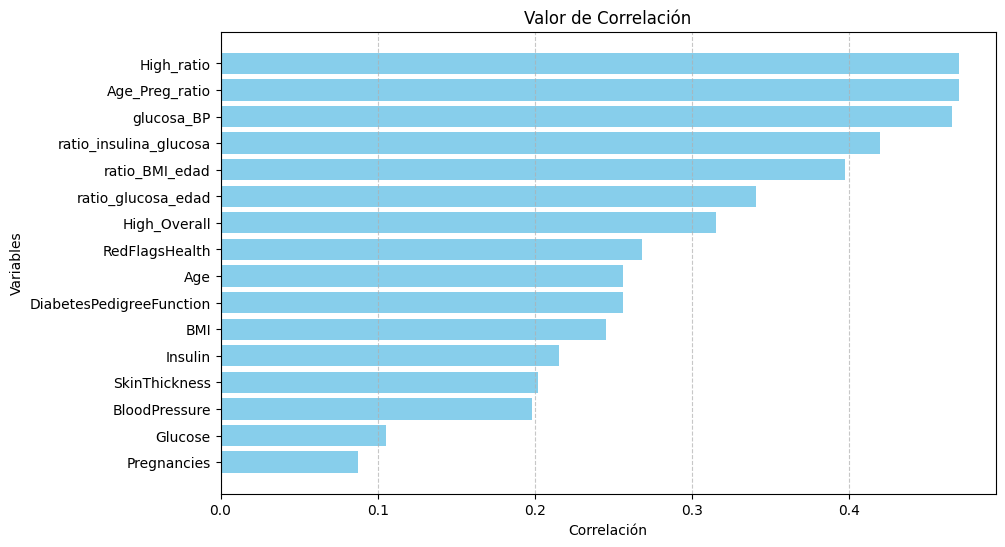

In [21]:
def ver_importancia_vars(df, y):
    X = df.drop(y, axis = 1)
    y = df[y]
    mi_scores(X,y)
    print('\n')
    correlaciones(X,y)

ver_importancia_vars(train_transf, 'Outcome')

# Feature Selection

Definiendo un comite de jueces, aplica una regresion logistica que vaya agregando una variable extra cada iteracion y dame el conjunto de variables que dio mejor resultado.

In [22]:
lista_back, modelo_back = sequential_feature_sel_logisticReg(X_train_transf, y_train)
results_df = pd.DataFrame.from_dict(modelo_back.subsets_, orient='index')
pd.DataFrame.from_dict(modelo_back.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.631578947368421, 0.6557377049180327, 0.7, 0...",0.650,"(Pregnancies, Glucose, BloodPressure, SkinThic...",0.038,0.030,0.015
15,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","[0.6896551724137931, 0.6774193548387096, 0.721...",0.677,"(Pregnancies, Glucose, BloodPressure, SkinThic...",0.035,0.027,0.014
14,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15)","[0.6666666666666666, 0.6774193548387096, 0.730...",0.679,"(Pregnancies, Glucose, BloodPressure, SkinThic...",0.034,0.027,0.013
13,"(0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15)","[0.7241379310344828, 0.6774193548387096, 0.698...",0.677,"(Pregnancies, Glucose, BloodPressure, SkinThic...",0.042,0.033,0.016
12,"(0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15)","[0.7333333333333333, 0.6774193548387096, 0.709...",0.679,"(Pregnancies, BloodPressure, SkinThickness, In...",0.050,0.039,0.019
11,"(2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15)","[0.6779661016949152, 0.6666666666666666, 0.688...",0.675,"(BloodPressure, SkinThickness, Insulin, BMI, D...",0.017,0.013,0.007
10,"(2, 3, 4, 5, 6, 8, 10, 11, 12, 15)","[0.6779661016949152, 0.6774193548387096, 0.721...",0.677,"(BloodPressure, SkinThickness, Insulin, BMI, D...",0.032,0.025,0.013
9,"(3, 4, 5, 6, 8, 10, 11, 12, 15)","[0.6666666666666666, 0.6774193548387096, 0.677...",0.673,"(SkinThickness, Insulin, BMI, DiabetesPedigree...",0.015,0.012,0.006
8,"(3, 4, 5, 6, 8, 10, 12, 15)","[0.6666666666666666, 0.6666666666666666, 0.677...",0.667,"(SkinThickness, Insulin, BMI, DiabetesPedigree...",0.010,0.007,0.004
7,"(3, 4, 5, 6, 8, 10, 12)","[0.6551724137931034, 0.6451612903225806, 0.689...",0.667,"(SkinThickness, Insulin, BMI, DiabetesPedigree...",0.024,0.019,0.009


<Figure size 1000x1200 with 0 Axes>

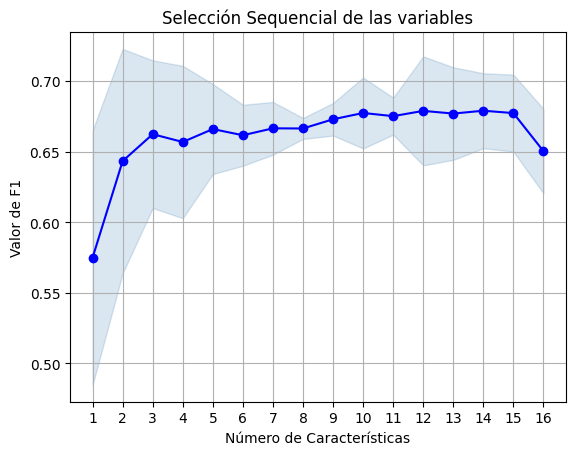

('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'RedFlagsHealth', 'High_Overall', 'ratio_glucosa_edad', 'ratio_BMI_edad', 'ratio_insulina_glucosa', 'Age_Preg_ratio', 'High_ratio')


In [23]:
def visualizar_sfs_codo(modelo) -> None:
    plt.figure(figsize = (10,12))
    fig1 = plot_sfs(modelo.get_metric_dict(), kind='std_dev')
    plt.title('Selección Sequencial de las variables')
    plt.xlabel('Número de Características')
    plt.ylabel('Valor de F1')
    plt.grid()
    plt.show()

visualizar_sfs_codo(modelo_back)
print(lista_back)
#Como lockear una iteracion X en caso de querer probar mas granularmente
#lista_vars_iter_10 = results_df.loc[results_df.index == 10, 'feature_names'].iloc[0]
#lista_vars_iter_10 = list(lista_vars_iter_10)
#lista_vars_iter_10

El primer modelo ha definido 14 variables como importantes de 16 posibles, ahora veremos que dice un modelo un poco más complejo (JUEZ N°2 - ÁRBOL DE DECISIÓN)

Promedio de precisión con validación cruzada (5 particiones): 0.6598


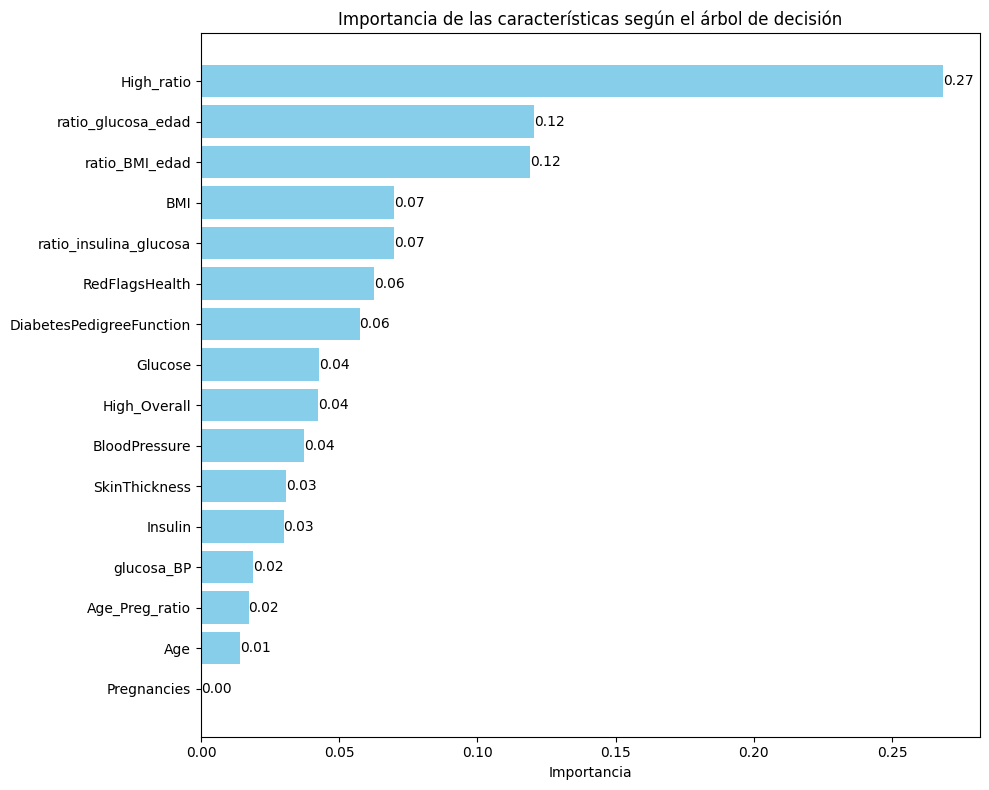

El numero de caracteristicas es de: 7 y son: ['BMI', 'DiabetesPedigreeFunction', 'RedFlagsHealth', 'ratio_glucosa_edad', 'ratio_BMI_edad', 'ratio_insulina_glucosa', 'High_ratio']


In [24]:
caracteristicas_importantes = importancia_segun_arbol(X_train_transf, y_train)
print(f"El numero de caracteristicas es de: {len(caracteristicas_importantes)} y son: {caracteristicas_importantes}")

#Opcional
Opcional, probar el Juez N°1 pero con un modelo random forest, aproximadamente demora unos 4 - 3 minutos.

In [25]:
#lista_back_rf, modelo_back_rf = sequential_feature_sel_RandomForest(X_train_set, y_train_set)
#pd.DataFrame.from_dict(modelo_back_rf.get_metric_dict()).T





In [26]:
#visualizar_sfs_codo(modelo_back_rf)
#print(lista_back_rf)

# Aplicando Filtro a las decisiones de los jueces

Aqui la idea es usar una regularizacion L1 (LASSO) fuerte para eliminar de la seleccion de caracteristicas propuestas por los dos modelos cuales son significativas

In [27]:
# Create copies of the transformed datasets
X_train_fs = X_train_transf.copy()
X_val_fs = X_val_transf.copy()

# Filter variables
variables_a_filtrar = sorted(set(caracteristicas_importantes).union(set(lista_back)))
X_train_fs = X_train_transf[sorted(variables_a_filtrar)]
X_val_fs = X_val_transf[sorted(variables_a_filtrar)]

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fs)

# Feature selection using Lasso LogisticRegression
sel = SelectFromModel(LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state = 2024), prefit=False)
sel.fit(X_train_scaled, y_train)

# Get selected feature names
selected_features = X_train_fs.columns[sel.get_support()].tolist()

print(f"Las variables escogidas inicialmente: {variables_a_filtrar}")
print(f"Las variables que quedaron después de un filtrado mediante Lasso: {selected_features}")

# Scale validation data
X_val_scaled = scaler.transform(X_val_fs)

# Baseline model with selected features
baseline = LogisticRegression()
baseline.fit(X_train_scaled[:, sel.get_support()], y_train)
baseline_preds = baseline.predict(X_val_scaled[:, sel.get_support()])
baseline_score = f1_score(y_val, baseline_preds)

print(f"El score F1 del baseline es de: {baseline_score:.4f}")

Las variables escogidas inicialmente: ['Age_Preg_ratio', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', 'Glucose', 'High_Overall', 'High_ratio', 'Insulin', 'Pregnancies', 'RedFlagsHealth', 'SkinThickness', 'ratio_BMI_edad', 'ratio_glucosa_edad', 'ratio_insulina_glucosa']
Las variables que quedaron después de un filtrado mediante Lasso: ['Age_Preg_ratio', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', 'Glucose', 'Insulin', 'Pregnancies', 'RedFlagsHealth', 'SkinThickness', 'ratio_BMI_edad', 'ratio_glucosa_edad']
El score F1 del baseline es de: 0.5570


# Características Seleccionadas:
['ratio_glucosa_edad', 'BloodPressure', 'Pregnancies', 'ratio_BMI_edad', 'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction', 'Glucose', 'BMI', 'Age_Preg_ratio', 'RedFlagsHealth']

In [28]:
#Aplicar a todos los conjuntos para tener simetria y poder evaluar
selected_features = sorted(selected_features)
standard = StandardScaler()
X_train_selected = X_train_transf[selected_features]
#X_train_selected.info()
X_val_selected = X_val_transf[selected_features]

X_test_selected = X_test_transf[selected_features]

X_train_selected_scaled = standard.fit_transform(X_train_selected)

X_val_selected_scaled = standard.transform(X_val_selected)

X_test_selected_scaled = standard.transform(X_test_selected)

# UnderSampling vs Oversampling
Es necesario escalar la data antes de hacer sampling de cualquier tipo para evitar ingresar uido extra entre la data

In [ ]:
pipeline_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('undersampler', RandomUnderSampler(random_state=2024))
])

X_train_under, y_train_under =  pipeline_under.fit_resample(X_train_selected, y_train)
X_val_under = pipeline_under.named_steps['scaler'].transform(X_val_selected)
print("Distribución original:", Counter(y_train))
print("Distribución después del undersampling:", Counter(y_train_under))

Distribución original: Counter({0: 274, 1: 158})
Distribución después del undersampling: Counter({0: 158, 1: 158})


In [ ]:
pipeline_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('oversampler', SMOTE(random_state=2024))
])

X_train_over, y_train_over = pipeline_over.fit_resample(X_train_selected, y_train)
X_val_over = pipeline_over.named_steps['scaler'].transform(X_val_selected)


print("Distribución original:", Counter(y_train))
print("Distribución después del oversampling:", Counter(y_train_over))


Distribución original: Counter({0: 274, 1: 158})
Distribución después del oversampling: Counter({0: 274, 1: 274})


In [ ]:
standard = StandardScaler()
X_train_selected_scaled = standard.fit_transform(X_train_selected)
X_val_selected_scaled = standard.transform(X_val_selected)


best_logistic_model_normal = hypertune_logistic_regression(X_train_selected_scaled, y_train)
evaluar_validation_set(best_logistic_model_normal, X_val_selected_scaled, y_val)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Puntaje promedio en CV (f1): 0.6734
Mejores hiperparámetros encontrados:
{'C': 0.001, 'l1_ratio': 0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
f1 en el conjunto de validación: 0.6458
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       100
           1       0.60      0.70      0.65        44

    accuracy                           0.76       144
   macro avg       0.73      0.75      0.73       144
weighted avg       0.78      0.76      0.77       144



In [ ]:
best_logistic_model_over = hypertune_logistic_regression(X_train_over, y_train_over)
evaluar_validation_set(best_logistic_model_over, X_val_over, y_val)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [ ]:
best_logistic_model_under = hypertune_logistic_regression(X_train_under, y_train_under)
evaluar_validation_set(best_logistic_model_under, X_val_under, y_val)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Puntaje promedio en CV (f1): 0.7630
Mejores hiperparámetros encontrados:
{'C': 0.0001, 'l1_ratio': 0.7, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
f1 en el conjunto de validación: 0.6476
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       100
           1       0.56      0.77      0.65        44

    accuracy                           0.74       144
   macro avg       0.72      0.75      0.72       144
weighted avg       0.78      0.74      0.75       144



# Conclusiones

Se debe proseguir sin Oversampling ni Undersampling debido a que se puede observar una gran varianza entre los valores de train vs test en ambos casos.

¿Pero si tiene mejor valor en f1 porque elegir el modelo normal (que tambien tiene una varianza considerable)?

Esto es porque nuestro modelo normal al tener menos diferencia en los resultados decimos que es mejor generalizando (prediciendo valores no vistos) que los modelos que tienen un "mejor rendimiento en términos de F1". En corto, mayor confianza.

¿Como se puede conseguir menos overfitting?
1. Disminuyendo aun más el numero de variables
2. Aplicar el punto 1 pero con regularización L1 (Lasso) para hacer 0 las vars no tan representativas, para esto habría que aumentar el coeficiente de regularización

# Bagging

Debido a que este conjunto de técnica sse basan en utilizar muestreo con reemplazo, el hecho de tener un conjunto de validacion no es necesario, ya que al hacer muestreo siempre en el conjunto de train hay un 33% de data que no es vista y puede ser utilizada como conjunto de validación.

In [ ]:
random_forest = hypertune_random_forest_with_bagging(X_train_selected, y_train)
evaluar_validation_set(random_forest, X_val_selected, y_val)
save_trained_model('RandomForest', random_forest)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
OOB Score del mejor modelo: 0.7407
Puntaje promedio en CV (f1): 0.7135
Mejores hiperparámetros encontrados:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_split': 40, 'n_estimators': 50}
f1 en el conjunto de validación: 0.6729
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       100
           1       0.57      0.82      0.67        44

    accuracy                           0.76       144
   macro avg       0.74      0.77      0.74       144
weighted avg       0.80      0.76      0.77       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/RandomForest.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/RandomForest.joblib'

In [ ]:
extra_tree = hypertune_extra_tree(X_train_selected, y_train)
evaluar_validation_set(extra_tree, X_val_selected, y_val)
save_trained_model('ExtraTree', extra_tree)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
OOB Score del mejor modelo: 0.7292
Puntaje promedio en CV (f1): 0.7048
Mejores hiperparámetros encontrados:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}
f1 en el conjunto de validación: 0.6465
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       100
           1       0.58      0.73      0.65        44

    accuracy                           0.76       144
   macro avg       0.72      0.75      0.73       144
weighted avg       0.78      0.76      0.76       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/ExtraTree.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/ExtraTree.joblib'

# Opcional - Trampa de métrica inflada


Es importante tener precaución al entrenar un modelo que utiliza técnicas de muestreo (oversampling o undersampling). Si además se activa el hiperparámetro class_weight='balanced', el modelo ajustará automáticamente la función de pérdida para penalizar más los errores en la clase minoritaria. Esto puede llevar a que el modelo tienda a predecir con mayor frecuencia la clase minoritaria, incluso cuando el desbalance original ya fue corregido mediante las técnicas de muestreo. Como resultado, se puede obtener una métrica inflada que no refleja el verdadero rendimiento del modelo.

In [ ]:
X_train_under = pd.DataFrame(X_train_under, columns=X_train_selected.columns)
X_val_under = pd.DataFrame(X_val_under, columns=X_train_selected.columns)
X_train_under_bag =  pd.concat([X_train_under, X_val_under], axis = 0)
y_train_under_bag =  pd.concat([y_train_under, y_val], axis = 0)


X_train_over = pd.DataFrame(X_train_over, columns=X_train_selected.columns)
X_val_over = pd.DataFrame(X_val_over, columns=X_train_selected.columns)
X_train_over_bag =  pd.concat([X_train_over, X_val_over], axis = 0)
y_train_over_bag =  pd.concat([y_train_over, y_val], axis = 0)

random_forest_under = hypertune_random_forest_with_bagging(X_train_under_bag, y_train_under_bag)
save_trained_model('RandomForestUnder', random_forest_under)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

results = {}

# Configuración base
random_forest_base = hypertune_random_forest_with_bagging(X_train_selected, y_train)
y_pred_base = random_forest_base.predict(X_test_selected)
results['Base'] = classification_report(y_test, y_pred_base, output_dict=True)

# Undersampling
y_pred_under = random_forest_under.predict(X_test_selected)
results['Undersampling'] = classification_report(y_test, y_pred_under, output_dict=True)

# Oversampling
random_forest_over = hypertune_random_forest_with_bagging(X_train_over_bag, y_train_over_bag)
y_pred_over = random_forest_over.predict(X_test_selected)
results['Oversampling'] = classification_report(y_test, y_pred_over, output_dict=True)

# Confusion Matrices
for name, preds in zip(['Base', 'Undersampling', 'Oversampling'],
                       [y_pred_base, y_pred_under, y_pred_over]):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['Class 0', 'Class 1'])
    disp.ax_.set_title(f"Confusion Matrix: {name}")
    plt.show()


# Más modelos

In [ ]:
ada_clf = hypertune_adaboost(X_train_selected, y_train)
evaluar_validation_set(ada_clf, X_val_selected, y_val)
save_trained_model('AdaBoost', ada_clf)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Puntaje promedio en CV (f1): 0.6674
Mejores hiperparámetros encontrados:
{'estimator__max_depth': 3, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'learning_rate': 0.1, 'n_estimators': 200}
f1 en el conjunto de validación: 0.5000
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       100
           1       0.48      0.52      0.50        44

    accuracy                           0.68       144
   macro avg       0.63      0.64      0.63       144
weighted avg       0.69      0.68      0.68       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/AdaBoost.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/AdaBoost.joblib'

In [ ]:
best_decision_tree = hypertune_decision_tree(X_train_selected, y_train)
evaluar_validation_set(best_decision_tree, X_val_selected, y_val)
save_trained_model('DecisionTree', best_decision_tree)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Puntaje promedio en CV (f1): 0.6589
Mejores hiperparámetros encontrados:
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 30, 'min_samples_split': 20}
f1 en el conjunto de validación: 0.6207
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       100
           1       0.63      0.61      0.62        44

    accuracy                           0.77       144
   macro avg       0.73      0.73      0.73       144
weighted avg       0.77      0.77      0.77       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/DecisionTree.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/DecisionTree.joblib'

In [ ]:
%%time
xgb = hypertune_xgboost(X_train_selected, y_train) #Ganador por mientras best_xgb = hypertune_xgboost(X_train_over, y_train_over)
evaluar_validation_set(xgb, X_val_selected, y_val)
save_trained_model('XGBoostScaled', xgb)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Puntaje promedio en CV (f1): 0.6281
Mejores hiperparámetros encontrados:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 50, 'subsample': 0.8}
f1 en el conjunto de validación: 0.6190
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       100
           1       0.65      0.59      0.62        44

    accuracy                           0.78       144
   macro avg       0.74      0.73      0.73       144
weighted avg       0.77      0.78      0.77       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/XGBoostScaled.joblib
CPU times: user 5.41 s, sys: 218 ms, total: 5.62 s
Wall time: 2min 4s


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/XGBoostScaled.joblib'

In [ ]:
best_catboost = hypertune_catboost(X_train_selected, y_train)
evaluar_validation_set(best_catboost, X_val_selected, y_val)
save_trained_model('best_catboost', best_catboost)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Puntaje promedio en CV (f1): 0.6587
Mejores hiperparámetros encontrados:
{'bagging_temperature': 0, 'border_count': 32, 'depth': 5, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'random_strength': 1}
f1 en el conjunto de validación: 0.5366
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.58      0.50      0.54        44

    accuracy                           0.74       144
   macro avg       0.69      0.67      0.68       144
weighted avg       0.73      0.74      0.73       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_catboost.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_catboost.joblib'

In [ ]:
standard = StandardScaler()
X_train_selected_scaled = standard.fit_transform(X_train_selected)
X_val_selected_scaled = standard.transform(X_val_selected)

best_svc = hypertune_svc(X_train_selected_scaled, y_train)
evaluar_validation_set(best_svc, X_val_selected_scaled, y_val)
save_trained_model('best_svc', best_svc)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Puntaje promedio en CV (f1): 0.6291
Mejores hiperparámetros encontrados:
{'C': 0.01, 'coef0': 0, 'gamma': 'scale', 'kernel': 'linear'}
f1 en el conjunto de validación: 0.5926
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.65      0.55      0.59        44

    accuracy                           0.77       144
   macro avg       0.73      0.71      0.72       144
weighted avg       0.76      0.77      0.76       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_svc.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_svc.joblib'

In [ ]:
best_knn = hypertune_svc(X_train_selected_scaled, y_train)
evaluar_validation_set(best_knn, X_val_selected_scaled, y_val)
save_trained_model('best_knn', best_knn)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Puntaje promedio en CV (f1): 0.6291
Mejores hiperparámetros encontrados:
{'C': 0.01, 'coef0': 0, 'gamma': 'scale', 'kernel': 'linear'}
f1 en el conjunto de validación: 0.5926
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.65      0.55      0.59        44

    accuracy                           0.77       144
   macro avg       0.73      0.71      0.72       144
weighted avg       0.76      0.77      0.76       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_knn.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_knn.joblib'

In [ ]:
best_logistic = hypertune_logistic_regression(X_train_selected_scaled, y_train)
evaluar_validation_set(best_logistic, X_val_selected_scaled, y_val)
save_trained_model('best_logistic', best_logistic)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Puntaje promedio en CV (f1): 0.6734
Mejores hiperparámetros encontrados:
{'C': 0.001, 'l1_ratio': 0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
f1 en el conjunto de validación: 0.6458
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       100
           1       0.60      0.70      0.65        44

    accuracy                           0.76       144
   macro avg       0.73      0.75      0.73       144
weighted avg       0.78      0.76      0.77       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_logistic.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/best_logistic.joblib'

# MLP

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

class DiabetesMLP(nn.Module):
    def __init__(self, input_size):
        super(DiabetesMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

    def train_model(self, X_train, y_train, X_val, y_val, epochs=200, learning_rate=0.01):
        def calculate_f1_score(y_true, y_pred):
            # Convertir tensores a numpy para cálculo de métricas
            y_true_np = y_true.numpy().flatten()
            y_pred_np = y_pred.numpy().flatten().round()

            # Calcular F1 Score
            f1 = f1_score(y_true_np, y_pred_np)

            # Calcular Matriz de Confusión
            cm = confusion_matrix(y_true_np, y_pred_np)

            return f1, cm

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Criterio de pérdida y optimizador
        criterio = nn.BCELoss()
        optimizador = optim.Adam(self.parameters(), lr=learning_rate)

        # Mejores resultados
        mejor_f1 = 0
        mejor_modelo = None

        # Entrenamiento
        for epoch in range(epochs):
            self.train()
            perdidas_epoch = []

            for batch_X, batch_y in train_loader:
                optimizador.zero_grad()
                predicciones = self(batch_X)

                perdida = criterio(predicciones, batch_y)
                perdida.backward()
                optimizador.step()

                perdidas_epoch.append(perdida.item())

            # Evaluación
            if (epoch + 1) % 10 == 0:
                self.eval()
                with torch.no_grad():
                    predicciones_val = self(X_val)

                    # Calcular F1 Score
                    f1, cm = calculate_f1_score(y_val, predicciones_val)

                    # Actualizar mejor F1 si es necesario
                    if f1 > mejor_f1:
                        mejor_f1 = f1
                        mejor_modelo = self.state_dict().copy()

                    print(f'Época {epoch+1}/{epochs}')
                    print(f'Pérdida de entrenamiento: {np.mean(perdidas_epoch):.16f}')
                    print(f'F1 Score: {f1:.16f}')
                    print('Matriz de Confusión:')
                    print(cm)
                    print('\n')

        # Cargar el mejor modelo
        if mejor_modelo is not None:
            self.load_state_dict(mejor_modelo)

        # Evaluación final
        self.eval()
        with torch.no_grad():
            predicciones_finales = self(X_val)
            f1_final, cm_final = calculate_f1_score(y_val, predicciones_finales)

            print('Resultados Finales:')
            print(f'Mejor F1 Score: {f1_final:.16f}')
            print('Matriz de Confusión Final:')
            print(cm_final)

        return self

# Código de uso (mantén tu código existente)
X_train_tensor = torch.FloatTensor(X_train_selected_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_selected_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

MLP = DiabetesMLP(input_size=X_train_tensor.shape[1])
best_MLP = MLP.train_model(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

Época 10/200
Pérdida de entrenamiento: 0.4115078348528456
F1 Score: 0.5952380952380952
Matriz de Confusión:
[[85 15]
 [19 25]]


Época 20/200
Pérdida de entrenamiento: 0.3785361079154191
F1 Score: 0.4722222222222222
Matriz de Confusión:
[[89 11]
 [27 17]]


Época 30/200
Pérdida de entrenamiento: 0.3472400529793016
F1 Score: 0.6363636363636364
Matriz de Confusión:
[[84 16]
 [16 28]]


Época 40/200
Pérdida de entrenamiento: 0.2601041247921617
F1 Score: 0.6122448979591837
Matriz de Confusión:
[[76 24]
 [14 30]]


Época 50/200
Pérdida de entrenamiento: 0.2271766226255783
F1 Score: 0.6304347826086957
Matriz de Confusión:
[[81 19]
 [15 29]]


Época 60/200
Pérdida de entrenamiento: 0.1741914872631982
F1 Score: 0.6019417475728155
Matriz de Confusión:
[[72 28]
 [13 31]]


Época 70/200
Pérdida de entrenamiento: 0.1222962755623653
F1 Score: 0.6315789473684210
Matriz de Confusión:
[[79 21]
 [14 30]]


Época 80/200
Pérdida de entrenamiento: 0.1802584085423775
F1 Score: 0.6200000000000000
Matriz de 

In [197]:
def evaluar_validation_set_MLP(modelo, X_test_set, y_test_set, flag=False):
    # Asegúrate de que el modelo está en modo de evaluación
    modelo.eval()

    # Realizar predicciones
    with torch.no_grad():
        y_pred_val = modelo(X_test_set)
        y_pred_val = y_pred_val.numpy().flatten().round()  # Convertir a numpy y redondear las predicciones

    # Calcular el F1 score
    score_f1 = f1_score(y_test_set.numpy().flatten(), y_pred_val)

    print(f"F1 en el conjunto de prueba: {score_f1:.4f}")
    print("Reporte de clasificación en el conjunto de prueba:")
    print(classification_report(y_test_set.numpy().flatten(), y_pred_val))

    if flag:
        return score_f1

X_test_tensor = torch.FloatTensor(X_test_selected_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)
joblib.dump(best_MLP.state_dict(), os.path.join("/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data", "MLP.joblib"))

['/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/MLP.joblib']

In [202]:
carpeta_modelos = "/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data"
modelos = {}

for archivo in os.listdir(carpeta_modelos):
    if archivo.endswith(".joblib"):
        nombre_modelo = archivo.split(".joblib")[0]
        modelos[nombre_modelo] = joblib.load(os.path.join(carpeta_modelos, archivo))


print("Modelos cargados:", modelos.keys())

metricas = []

for nombre, modelo in modelos.items():
    print(f"Evaluando modelo: {nombre}")
    if nombre == 'MLP':
        break
    if nombre in ['best_svc', 'best_knn', 'best_logistic']:
        f1 = evaluar_validation_set(modelo, X_val_selected_scaled, y_val, True)
    else:
        f1 = evaluar_validation_set(modelo, X_val_selected, y_val, True)

    metricas.append({"Modelo": nombre, "F1_Score": f1})
df_metricas = pd.DataFrame(metricas)
df_metricas = df_metricas.sort_values(by = 'F1_Score', ascending=False)
df_metricas


Modelos cargados: dict_keys(['RandomForest', 'ExtraTree', 'AdaBoost', 'DecisionTree', 'XGBoostScaled', 'best_catboost', 'best_svc', 'best_knn', 'best_logistic', 'MLP', 'voting_bl_rf_knn', 'voting_lr_xgb_rf', 'voting_S_xgb_rf_lr_et'])
Evaluando modelo: RandomForest
f1 en el conjunto de validación: 0.6729
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       100
           1       0.57      0.82      0.67        44

    accuracy                           0.76       144
   macro avg       0.74      0.77      0.74       144
weighted avg       0.80      0.76      0.77       144

Evaluando modelo: ExtraTree
f1 en el conjunto de validación: 0.6465
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       100
           1       0.58      0.73      0.65        44

    accuracy              

,Modelo,F1_Score
0,RandomForest,0.673
1,ExtraTree,0.646
8,best_logistic,0.646
3,DecisionTree,0.621
4,XGBoostScaled,0.619
6,best_svc,0.593
7,best_knn,0.593
5,best_catboost,0.537
2,AdaBoost,0.500


La idea aquí es anexar los resultados de entrenamiento del modelo y ver que tan relacionados están las predicciones y agarrar aquellos modelos que son mas distintos (para intentar capturar información nueva o diferentes puntos de vista). Todo esta selección se hará mediante sets de validación.

#Voting

Obteniendo predicciones del modelo: RandomForest
Obteniendo predicciones del modelo: ExtraTree
Obteniendo predicciones del modelo: AdaBoost
Obteniendo predicciones del modelo: DecisionTree
Obteniendo predicciones del modelo: XGBoostScaled
Obteniendo predicciones del modelo: best_catboost
Obteniendo predicciones del modelo: best_svc
Obteniendo predicciones del modelo: best_knn
Obteniendo predicciones del modelo: best_logistic
Obteniendo predicciones del modelo: MLP


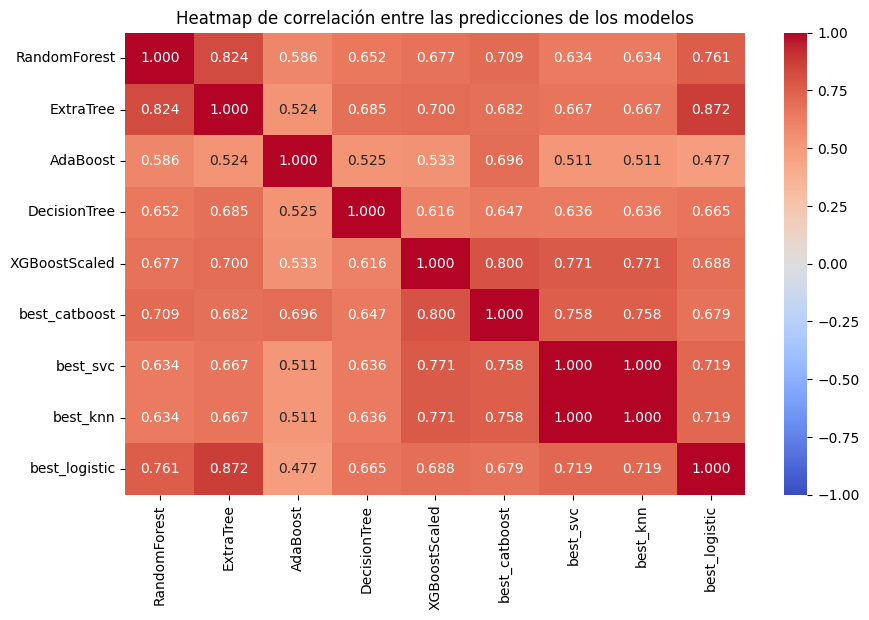

In [203]:
predicciones_train = {}
for nombre, modelo in modelos.items():
    print(f"Obteniendo predicciones del modelo: {nombre}")
    if nombre == 'MLP':
        break
    if nombre in ['best_svc', 'best_knn', 'best_logistic']:
        predicciones_train[nombre] = modelo.predict(X_train_selected_scaled)
    else:
        predicciones_train[nombre] = modelo.predict(X_train_selected)


base_predictions_train = pd.DataFrame(predicciones_train)
corr_matrix = base_predictions_train.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", vmin=-1, vmax=1)
plt.title("Heatmap de correlación entre las predicciones de los modelos")
plt.show()

# Hard Voting

Armar un conjunto de modelos con los ya entrenados que haran la funcion de un juzgado, lo que diga la mayoria es lo que va.

In [204]:
from sklearn.ensemble import VotingClassifier

voting_bl_rf_knn = VotingClassifier(estimators=[
    ('best_logistic', modelos['best_logistic']),
    ('RandomForest', modelos['RandomForest']),
    ('best_knn', modelos['best_knn'])
], voting='hard')  # 'hard' para votación mayoritaria

# Ajusta el modelo en el conjunto de entrenamiento
voting_bl_rf_knn.fit(X_train_selected_scaled, y_train)

evaluar_validation_set(voting_bl_rf_knn, X_val_selected_scaled, y_val)
save_trained_model('voting_bl_rf_knn', voting_bl_rf_knn)


f1 en el conjunto de validación: 0.6596
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       100
           1       0.62      0.70      0.66        44

    accuracy                           0.78       144
   macro avg       0.74      0.76      0.75       144
weighted avg       0.79      0.78      0.78       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/voting_bl_rf_knn.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/voting_bl_rf_knn.joblib'

In [205]:
from sklearn.ensemble import VotingClassifier

voting_lr_xgb_rf = VotingClassifier(estimators=[
    ('best_logistic', modelos['best_logistic']),
    ('XGBoostScaled', modelos['XGBoostScaled']),
    ('RandomForest', modelos['RandomForest']),

], voting='hard')  # 'hard' para votación mayoritaria

# Ajusta el modelo en el conjunto de entrenamiento
voting_lr_xgb_rf.fit(X_train_selected_scaled, y_train)

evaluar_validation_set(voting_lr_xgb_rf, X_val_selected_scaled, y_val)
save_trained_model('voting_lr_xgb_rf', voting_lr_xgb_rf)


f1 en el conjunto de validación: 0.6667
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       100
           1       0.62      0.73      0.67        44

    accuracy                           0.78       144
   macro avg       0.74      0.76      0.75       144
weighted avg       0.79      0.78      0.78       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/voting_lr_xgb_rf.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/voting_lr_xgb_rf.joblib'

# Soft Voting

La idea es la misma solo que en vez de hacer lo que la mayoría dice aqui se selecciona la prediccion que tenga mayor probabilidad de ser cierta de todos los modelos.

In [206]:
from sklearn.ensemble import VotingClassifier

voting_S_xgb_rf_lr_et    = VotingClassifier(estimators=[
    ('XGBoostScaled', modelos['XGBoostScaled']),
    ('RandomForest', modelos['RandomForest']),
    ('best_logistic', modelos['best_logistic']),
    ('ExtraTree', modelos['ExtraTree'])
], voting='soft')  # 'hard' para votación mayoritaria

# Ajusta el modelo en el conjunto de entrenamiento
voting_S_xgb_rf_lr_et.fit(X_train_selected_scaled, y_train)

evaluar_validation_set(voting_S_xgb_rf_lr_et, X_val_selected_scaled, y_val)
save_trained_model('voting_S_xgb_rf_lr_et', voting_S_xgb_rf_lr_et)

f1 en el conjunto de validación: 0.6596
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       100
           1       0.62      0.70      0.66        44

    accuracy                           0.78       144
   macro avg       0.74      0.76      0.75       144
weighted avg       0.79      0.78      0.78       144

Modelo guardado en: /content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/voting_S_xgb_rf_lr_et.joblib


'/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data/voting_S_xgb_rf_lr_et.joblib'

# Escogiendo el modelo Ganador

In [207]:
# Definir la carpeta donde se encuentran los modelos
carpeta_modelos = "/content/drive/MyDrive/Scikit-Learn-keras-TensorFlow-Book/Semestral/data"
modelos = {}

# Cargar los modelos
for archivo in os.listdir(carpeta_modelos):
    if archivo.endswith(".joblib"):
        nombre_modelo = archivo.split(".joblib")[0]

        if nombre_modelo == "MLP":
            # Cargar los pesos del MLP
            state_dict = joblib.load(os.path.join(carpeta_modelos, archivo))

            # Reconstruir el modelo con la arquitectura original
            mlp_model = DiabetesMLP(input_size=X_test_tensor.shape[1])  # Asegúrate de usar el tamaño de entrada correcto
            mlp_model.load_state_dict(state_dict)

            # Añadir el modelo reconstruido al diccionario
            modelos[nombre_modelo] = mlp_model
        else:
            # Cargar otros modelos normalmente
            modelos[nombre_modelo] = joblib.load(os.path.join(carpeta_modelos, archivo))

# Verificar los modelos cargados
print("Modelos cargados:", modelos.keys())

# Evaluar los modelos y almacenar métricas
metricas = []

for nombre, modelo in modelos.items():
    print(f"Evaluando modelo: {nombre}")

    if nombre == 'MLP':
        f1 = evaluar_validation_set_MLP(modelo, X_test_tensor, y_test_tensor, True)
    elif nombre in ['best_svc', 'best_knn', 'best_logistic']:
        f1 = evaluar_validation_set(modelo, X_test_selected_scaled, y_test, True)
    else:
        f1 = evaluar_validation_set(modelo, X_test_selected, y_test, True)

    metricas.append({"Modelo": nombre, "F1_Score": f1})

# Crear un DataFrame con las métricas de los modelos
df_metricas = pd.DataFrame(metricas)

# Ordenar el DataFrame por el F1 Score
df_metricas = df_metricas.sort_values(by='F1_Score', ascending=False)

# Mostrar las métricas
df_metricas


Modelos cargados: dict_keys(['RandomForest', 'ExtraTree', 'AdaBoost', 'DecisionTree', 'XGBoostScaled', 'best_catboost', 'best_svc', 'best_knn', 'best_logistic', 'MLP', 'voting_bl_rf_knn', 'voting_lr_xgb_rf', 'voting_S_xgb_rf_lr_et'])
Evaluando modelo: RandomForest
f1 en el conjunto de validación: 0.7143
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       126
           1       0.62      0.83      0.71        66

    accuracy                           0.77       192
   macro avg       0.76      0.79      0.76       192
weighted avg       0.80      0.77      0.78       192

Evaluando modelo: ExtraTree
f1 en el conjunto de validación: 0.7097
Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       126
           1       0.62      0.83      0.71        66

    accuracy              

,Modelo,F1_Score
0,RandomForest,0.714
1,ExtraTree,0.710
8,best_logistic,0.701
3,DecisionTree,0.691
6,best_svc,0.687
7,best_knn,0.687
9,MLP,0.680
4,XGBoostScaled,0.652
5,best_catboost,0.652
11,voting_lr_xgb_rf,0.646


# El modelo Ganador es el RandomForest



In [210]:
random_preds = modelos['RandomForest'].predict(X_test_selected)
confusion_matrix(y_test, random_preds)

array([[93, 33],
       [11, 55]])

El modelo es más eficiente al identificar la clase 0 que la clase 1. Aunque el recuerdo para la clase 1 es alto, la precisión es moderada debido a los falsos positivos.


# Recomendaciones:

Mejora en la calidad de los datos: Si se busca obtener un mejor rendimiento, recomendaría aumentar la cantidad de datos disponibles, especialmente para balancear la clase 1. Si esta opción no es viable, sugiero realizar una búsqueda de hiperparámetros más exhaustiva utilizando técnicas de hipertuneo bayesiano, lo que podría ayudar a mejorar los resultados. Sin embargo, si no se requiere un F1-score extremadamente alto, el uso de un modelos más simple y explicables, como Regresión Logística o Árboles de Decisión, podría ser una opción viable, ya que ofrecen una mayor interpretabilidad a cambio de una ligera disminución en el F1-score.

Modelos avanzados: Si se desea mejorar aún más el rendimiento, se podrían explorar más a fondo los enfoque de Stacking o Voting, incorporando la MLP diseñada. También es posible mejorar el modelo MLP, pero debido a la limitación de tiempo, esta fue una opción que no se pudo explorar en profundidad.

También sugeriría la creación de nuevas características basadas en el conocimiento de expertos en el campo de la diabetes. Esto permitiría redefinir los límites de la columna HealthRedFlags y podría ayudar a capturar patrones subyacentes en los datos, como ratios entre variables. Además, sería beneficioso explorar otros métodos de selección de características, como el filtrado basado en la importancia de las características dentro de grupos de modelos. Este enfoque no se aplicó en este caso, ya que el objetivo era centrarse en las técnicas aprendidas en los capítulos 2 a 8 del libro.

Ajuste de la función de pérdida: Mi última recomendación es ajustar la función de pérdida mediante su atributo make_scorer, incorporando una penalización adicional a los fallos cometidos en los falsos positivos (33 errores es bastante). Esto podría ayudar a mejorar el rendimiento en el caso de desequilibrio de clases. También sería bueno explorar el umbral de decisión para las predicciones y asi disminuir la tasa de falsos positivos.

